<a href="https://colab.research.google.com/github/hmcgoran/Latest-GP16-Regression-N2O-Model/blob/main/V4_GP16_multiple_regression_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GP16 Multiple Regression V4 Overview (w/ Monte Carlo)
This code uses an isotope mixing model adapted from Peters et al. 2018 which analyzed NO3- end members in the transect. The objective is to quantify the relative contributions of four N2O end members (background, AOA, incomplete denitrification (ID), and Oxygen Deficient Zone (ODZ)) in the GP16 transect. Broadly, the methodology involves defining the delta values of background N2O, AOA-produced N2O, ID-produced N2O, N2O produced in the ODZ, and a multiple linear least squares regression to estimate the relative contributions of each end member.

The Colab is integrated with two Google Sheets: V4_COLAB Final GP16 Regression Model and V4_COLAB Water Mass Delta Definitions. If you want to run this code and make edits to the Colab, you should make a copy of the Colab + two sheets I linked above, and then update the links to the sheet in the Colab. The links needing change are distinguished in a section below using pound signs as follows:
############################################################

worksheet_name = gc.open_by_url('Google Sheet URL')

worksheet_name = gc.open_by_url('Google Sheet URL')

############################################################

The Google Sheet URL can be obtained by clicking share > copy link in the Google Sheet.

The code is based on data from GP16, meaning that all of the sheets referenced are also specific to GP16. To adapt this code to other cases, you would need to link different Google Sheets, change variable names, column names, and anything else that is specific to the region.

# Logistics, Package Imports, Function Definitions, and Google Sheet Integration

First, you will need to give Google Colab permission to access your Drive, which allows the formation of a live connection between Google Sheets and Colab.

In [1]:
######## Makes it possible to have a live connection between Google Sheets and Colab #######
from google.colab import auth
import gspread
from google.auth import default

# Authenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

The next two lines make it possible to import and export to the two Google Sheets mentioned in the overview.

**IF YOU WANT TO RUN THIS COLAB ON YOUR OWN AND MAKE EDITS, CHANGE THESE TWO LINKS AS DESCRIBED IN THE OVERVIEW**

In [2]:
######################################################################
# Importing data live from the Google Sheets titled: "V4_COLAB Monte Carlo Final GP16 Regression Model"
final_gp16_regression_model = gc.open_by_url(
    'https://docs.google.com/spreadsheets/d/1wGER67HAfrxMDrzXcIlw4ojUQhGLtaZE8gq69vRj5hk/edit?usp=sharing')

# Importing data live from the Google Sheets titled: "V4_COLAB Monte Carlo Water Mass Delta Definitions"
water_mass_delta_definitions = gc.open_by_url(
    'https://docs.google.com/spreadsheets/d/11q_4xOLxm7KRKdBoHDtBVJTJZviCswpKJ7uhs99acH4/edit?usp=sharing')
######################################################################

Next, the functions below need to be imported, some which are used throughout the Colab, and others that are only used once (i.e. csaps and cvxpy). This may take a minute or two, as some of the packages (gsw and csaps) need to be installed.

In [3]:
import pandas as pd
import numpy as np
!pip install gsw # For the potential density calculations
import gsw as gsw
!pip install csaps # For the cubic spline interpolation
from csaps import csaps
import matplotlib.pyplot as plt # For plotting
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.6 MB/s eta 0:00:00


The next section defines three functions that are frequently used throughout the colab. See the function descriptions in the comments.

In [4]:
def import_sheet_as_df(worksheet_name, tab_name):
  '''
  Function that allows you to import sheets and values from
  various Google Sheets tabs. tab_name should be entered as a string and
  worksheet_name = gc.open_by_url('Google Sheet URL'), which should be defined
  prior to calling this function.
  '''
  sheet = worksheet_name.worksheet(tab_name) # Obtains the tab/worksheet of interest from the main Google Sheet that is linked
  rows = sheet.get_all_values() # get_all_values gives a list of rows
  df = pd.DataFrame(rows[1:], columns=rows[0]) # Deletes the row numbers column and makes the first row the headers
  return df

def export_df_to_sheet(worksheet_name, new_tab_name, df_to_export):
  '''
  This function allows you to export a dataframe as a new tab in the Google
  Sheet.  worksheet_name = gc.open_by_url('Google Sheet URL'),
  new_tab_name is a string for what you want to call the new tab, df_to_export
  is the dataframe you are exporting to the sheet
  '''
  new_sheet = worksheet_name.add_worksheet(new_tab_name, rows=400, cols = 85)
  new_sheet.update([df_to_export.columns.values.tolist()] + df_to_export.values.tolist())

def convert_column(dataframe, column_name):
  '''
  This function converts a column in a dataframe to a 1-D array.
  There might be an easier way to do this, but I am not aware of it.
  '''
  prelim_list = list(dataframe[column_name])
  variable_array = [float(i) for i in prelim_list]
  return variable_array

# Preliminary Data Processing and Merges

The following code then merges the N2O dataset, metadata, and water mass percentages into one big dataset by Sample ID. This is done through two merges. Potential density is calculated using the [gsw package](https://teos-10.github.io/GSW-Python/conversions.html) and added as a column to the dataframe before merging with the water mass data.

In [5]:
# Importing different tabs of the "Final GP16 Regression Model" Google Sheets as dataframes
n2o = import_sheet_as_df(final_gp16_regression_model, "GP16 N2O Data")
water_mass = import_sheet_as_df(final_gp16_regression_model, "Water Mass Data")

# Merge N2O data with water mass data
post_merge = pd.merge(n2o, water_mass, on='Sample ID')

# The next line will export the merged data to Google Sheets under the tab "Post-Merge Data Colab"
# You should comment the following line out if you don't need to export the data (i.e. if it is already there from a prior run)
# export_df_to_sheet(final_gp16_regression_model, 'Post-Merge Data Colab', post_merge)

# Background N2O Definition
Background N2O is the final term we use to describe preformed N2O, which is why "pre" is still used in this code and in the sheet.

## Background Definition - Import Intermediate + Deep Water Mass Definitions

This section extracts all of the intermediate and deep water mass definitions from the Water Mass Delta Definitions Google Sheet and assigns them to variables for later use. If you change a value in the sheet, it will automatically update in the Google Colab.

In [ ]:
inter_deep_def = import_sheet_as_df(water_mass_delta_definitions, "Intermediate/Deep Definitions")

# NOTE: If you change a value in the sheet, it will automatically update when imported to Google Colab
AAIW_N2O = inter_deep_def.loc[0]['[N2O]']
EQPIW_N2O = inter_deep_def.loc[1]['[N2O]']
UCDW_N2O = inter_deep_def.loc[2]['[N2O]']
PDW_N2O = inter_deep_def.loc[3]['[N2O]']
LCDW_N2O = inter_deep_def.loc[4]['[N2O]']
AABW_N2O = inter_deep_def.loc[5]['[N2O]']

AAIW_D15NA = inter_deep_def.loc[0]['d15Na']
EQPIW_D15NA = inter_deep_def.loc[1]['d15Na']
UCDW_D15NA = inter_deep_def.loc[2]['d15Na']
PDW_D15NA = inter_deep_def.loc[3]['d15Na']
LCDW_D15NA = inter_deep_def.loc[4]['d15Na']
AABW_D15NA = inter_deep_def.loc[5]['d15Na']

AAIW_D15NB = inter_deep_def.loc[0]['d15Nb']
EQPIW_D15NB = inter_deep_def.loc[1]['d15Nb']
UCDW_D15NB = inter_deep_def.loc[2]['d15Nb']
PDW_D15NB = inter_deep_def.loc[3]['d15Nb']
LCDW_D15NB = inter_deep_def.loc[4]['d15Nb']
AABW_D15NB = inter_deep_def.loc[5]['d15Nb']

AAIW_D18O = inter_deep_def.loc[0]['dO18']
EQPIW_D18O = inter_deep_def.loc[1]['dO18']
UCDW_D18O = inter_deep_def.loc[2]['dO18']
PDW_D18O = inter_deep_def.loc[3]['dO18']
LCDW_D18O = inter_deep_def.loc[4]['dO18']
AABW_D18O = inter_deep_def.loc[5]['dO18']

AAIW_O2 = inter_deep_def.loc[0]['O2']
EQPIW_O2 = inter_deep_def.loc[1]['O2']
UCDW_O2 = inter_deep_def.loc[2]['O2']
PDW_O2 = inter_deep_def.loc[3]['O2']
LCDW_O2 = inter_deep_def.loc[4]['O2']
AABW_O2 = inter_deep_def.loc[5]['O2']


## Background Definition - Import Thermocline Water Mass Definitions and Interpolate

In order to calculate the preformed delta values for each sample, we have to get a density-specific delta definition for each sample in the thermocline. This code imports the raw data that defines the three thermocline water masses (ESSW, ESPIW, and SPCW) from the Water Mass Delta Definitions Google Sheet. Then, the code interpolates the data using a cubic spline interpolation function (csaps package) between potential density 26-27 in 0.01 increments. If this is confusing, see the next section, which visualizes this code in plots.

In [ ]:
def univariate(dataframe, variable):
  '''
  This function takes the raw data for each N2O variable and
  interpolates it over the 26-27 sigma theta range in 0.01 increments.
  Eventually, these interpolated values are used to help calculate
  preformed values. See https://csaps.readthedocs.io/en/latest/ for
  documentation on the cubic spline approximation function. Currently,
  a smoothing factor of 0.99 is used, however this number can be changed
  to be more or less sensitive to changes in the raw data.
  '''
  x = np.linspace(26, 27, 100)  # Create 100 density values for interpolation
  spline = csaps(dataframe["Density"], dataframe[variable], x, smooth=0.99)
  return spline

# Imports the raw data for each of the three thermocline water masses
essw = import_sheet_as_df(water_mass_delta_definitions, "ESSW Definition")
espiw = import_sheet_as_df(water_mass_delta_definitions, "ESPIW Definition")
spcw = import_sheet_as_df(water_mass_delta_definitions, "SPCW Definition")

density = np.linspace(26, 27, 100) # Defines an array of "x-values" over which we want to interpolate
espiw_df = pd.DataFrame(density, columns=['Density'])  # Create 100 row empty dataframe for interpolated values
essw_df = pd.DataFrame(density, columns=['Density'])
spcw_df = pd.DataFrame(density, columns=['Density'])

variables = ['[N2O]', 'd15Na', 'd15Nb', 'd18O', 'd15Nbulk', 'SP', 'O2'] # Variables to interpolate
for variable in variables:
  espiw_df[variable] = univariate(espiw, variable) # Adds 100-point interpolation to the new dataframe for every variable
  essw_df[variable] = univariate(essw, variable)
  spcw_df[variable] = univariate(spcw, variable)

espiw_df['Density'] = espiw_df['Density'].round(2) # Rounds the values to two decimal places
essw_df['Density'] = essw_df['Density'].round(2)
spcw_df['Density'] = spcw_df['Density'].round(2)

print(espiw_df)
print(essw_df)
print(spcw_df)

# export_df_to_sheet(water_mass_delta_definitions, 'ESSW Definitions Post-Interpolation (12/17)', essw_df)
# export_df_to_sheet(water_mass_delta_definitions, 'ESPIW Definitions Post-Interpolation (12/17)', espiw_df)
# export_df_to_sheet(water_mass_delta_definitions, 'SPCW Definitions Post-Interpolation (12/17)', spcw_df)

    Density      [N2O]      d15Na     d15Nb       d18O  d15Nbulk         SP  \
0     26.00  12.802123  14.528101  2.485872  46.053571  8.502873  12.041648   
1     26.01  13.200842  14.567541  2.430016  46.268373  8.494904  12.136998   
2     26.02  13.598234  14.607090  2.374938  46.481649  8.487377  12.231679   
3     26.03  13.994451  14.646735  2.320547  46.693576  8.480240  12.325769   
4     26.04  14.389646  14.686464  2.266755  46.904329  8.473444  12.419344   
..      ...        ...        ...       ...        ...       ...        ...   
95    26.96  56.813142  16.776201 -2.907608  55.385595  6.940823  19.685096   
96    26.97  57.257072  16.808793 -2.898062  55.283683  6.961772  19.708180   
97    26.98  57.699851  16.841507 -2.887923  55.181328  6.983075  19.730795   
98    26.99  58.142124  16.874269 -2.877344  55.078701  7.004619  19.753018   
99    27.00  58.584410  16.907057 -2.866441  54.975925  7.026337  19.774944   

            O2  
0   154.444628  
1   152.113405  


## Background Definition - Thermocline Interpolation and Profile Plots

This section visualizes what was done in the last section, where each thermocline water mass variable was interpolated from 26-27 sigma theta.

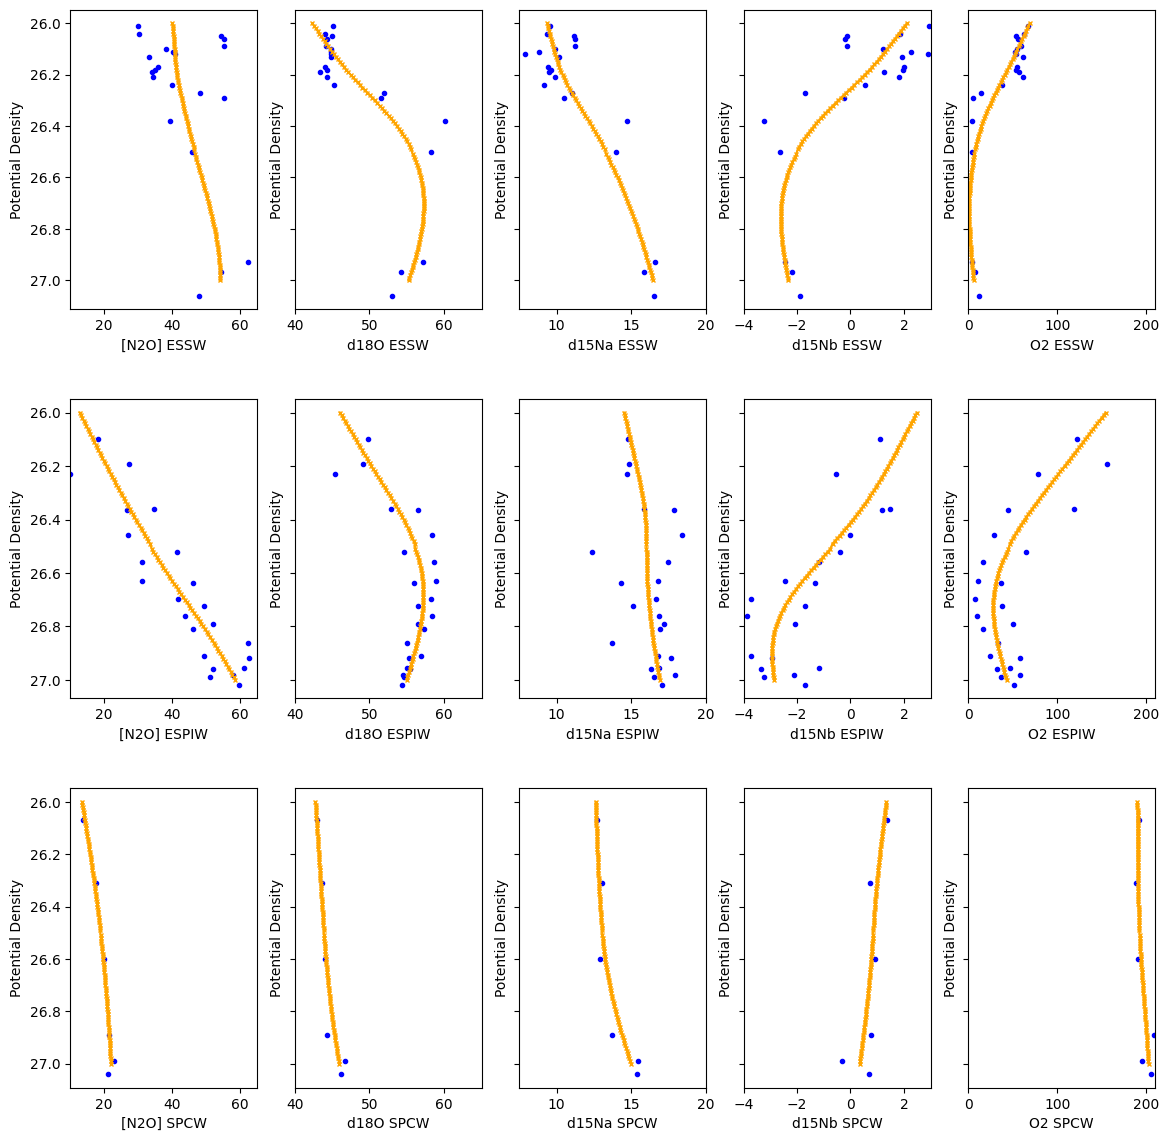

In [ ]:
def thermocline_plots(row, col, min, max, watermass_df, col_name, spline_df, var_label):
  '''
  This is a general function for plotting the interpolations and raw data values
  for each water mass and each variable. Row = plot row, col = plot col,
  min = x-axis minimum, max = x-axis maximum, watermass_df = imported dataframe
  containing the raw values, col_name = the variable of interest, spline_df =
  the dataframe that holds the interpolated value, var_label = name for the x-axis
  '''
  watermass_df[col_name] = watermass_df[col_name].astype(float) # Raw Data Values
  watermass_df['Density'] = watermass_df['Density'].astype(float) # Density corresponding to raw data
  ax[row, col].plot(watermass_df[col_name], watermass_df['Density'], 'bo', markersize=3)  # Plot original points
  ax[row, col].plot(spline_df[col_name], spline_df['Density'], 'x-', c='orange', markersize=3)  # Plot spline
  ax[row, col].set_xlim(min, max)
  ax[row, col].set_ylabel('Potential Density')
  ax[row, col].set_xlabel(var_label)

fig, ax = plt.subplots(3, 5, sharey='row') # Make the y-axis the same for all rows
fig.set_size_inches(14, 14) # Size of the panel
fig.subplots_adjust(hspace = 0.3, wspace = 0.2) # Space between plots

# ESSW Plots
ax[0, 0].invert_yaxis()
thermocline_plots(0, 0, 10, 65, essw, '[N2O]', essw_df, "[N2O] ESSW")
thermocline_plots(0, 1, 40, 65, essw, 'd18O', essw_df, "d18O ESSW")
thermocline_plots(0, 2, 7.5, 20, essw, 'd15Na', essw_df, "d15Na ESSW")
thermocline_plots(0, 3, -4, 3, essw, 'd15Nb', essw_df, "d15Nb ESSW")
thermocline_plots(0, 4, 0, 210, essw, 'O2', essw_df, "O2 ESSW")

# ESPIW Plots
ax[1, 0].invert_yaxis()
thermocline_plots(1, 0, 10, 65, espiw, '[N2O]', espiw_df, "[N2O] ESPIW")
thermocline_plots(1, 1, 40, 65, espiw, 'd18O', espiw_df, "d18O ESPIW")
thermocline_plots(1, 2, 7.5, 20, espiw, 'd15Na', espiw_df, "d15Na ESPIW")
thermocline_plots(1, 3, -4, 3, espiw, 'd15Nb', espiw_df, "d15Nb ESPIW")
thermocline_plots(1, 4, 0, 210, espiw, 'O2', espiw_df, "O2 ESPIW")

# SPCW Plots
ax[2, 0].invert_yaxis()
thermocline_plots(2, 0, 10, 65, spcw, '[N2O]', spcw_df, "[N2O] SPCW")
thermocline_plots(2, 1, 40, 65, spcw, 'd18O', spcw_df, "d18O SPCW")
thermocline_plots(2, 2, 7.5, 20, spcw, 'd15Na', spcw_df, "d15Na SPCW")
thermocline_plots(2, 3, -4, 3, spcw, 'd15Nb', spcw_df, "d15Nb SPCW")
thermocline_plots(2, 4, 0, 210, spcw, 'O2', spcw_df, "O2 SPCW")

plt.show()

## Background Definition - Calculate Sample-Specific Preformed Values

This section takes all of the previously defined data to calculate sample-by-sample preformed d18O, d15Na, d15Nb, and O2. First, the water mass percentage values from Peters 2018 are imported as lists.

In [ ]:
# post_merge = import_sheet_as_df(final_gp16_regression_model, "Post-Merge Data Colab")

def water_mass_percent(column):
  '''
  This function takes the column of water percent values for the specified
  water mass from the post-merge dataset and divides all values by 100
  so that the percentages are converted to proportions and able to be
  incorporated into the preformed calculation.
  '''
  pct_import = post_merge[column].tolist()
  pct_list = [float(num) / 100 for num in pct_import] # Convert the proportions from Peters et al. 2018 to percentages
  return pct_list

essw_pct = water_mass_percent('ESSW_PCT')
espiw_pct = water_mass_percent('ESPIW_PCT')
spcw_pct = water_mass_percent('SPCW_PCT')
aaiw_pct = water_mass_percent('AAIW_PCT')
eqpiw_pct = water_mass_percent('EQPIW_PCT')
ucdw_pct = water_mass_percent('UCDW_PCT')
pdw_pct = water_mass_percent('PDW_PCT')
lcdw_pct = water_mass_percent('LCDW_PCT')
aabw_pct = water_mass_percent('AABW_PCT')

Next, isotope mass balance is used to calculate the preformed values for each sample using this equation: Σ over all water masses (water mass % * water mass definition * [N2O]) / Σ over all water masses (water mass % * [N2O])

In [ ]:
d18O_pre = [] # Set up empty lists to hold the calculated preformed values
d15Na_pre = []
d15Nb_pre = []
o2_pre = []
samp_density = post_merge['Potdens'].astype(float).round(2).tolist()

for i in range(len(samp_density)): # Loops through every sample in the entire dataset
  if 26 <= samp_density[i] <= 27: # If the sample is in the thermocline
    row_espiw = espiw_df.loc[espiw_df['Density'] == samp_density[i]]  # Obtains the row from the espiw_df for the respective density
    row_essw = essw_df.loc[essw_df['Density'] == samp_density[i]]
    row_spcw = spcw_df.loc[spcw_df['Density'] == samp_density[i]]
  else:
    # If the sample density is not in the thermocline (26-27 sigma theta), then we make the values 0
    row_espiw = pd.DataFrame(np.zeros((1,6)), columns = ['Density', '[N2O]', 'd15Na','d15Nb', 'd18O', 'O2'])
    row_essw = pd.DataFrame(np.zeros((1,6)), columns = ['Density', '[N2O]', 'd15Na','d15Nb', 'd18O', 'O2'])
    row_spcw = pd.DataFrame(np.zeros((1,6)), columns = ['Density', '[N2O]', 'd15Na','d15Nb', 'd18O', 'O2'])

  # Calculate the denominator, which is just water mass percent * [N2O] all summed together
  denominator = (
    float(essw_pct[i]) * float(row_essw['[N2O]']) +
    float(espiw_pct[i]) * float(row_espiw['[N2O]']) +
    float(spcw_pct[i]) * float(row_spcw['[N2O]']) +
    float(aaiw_pct[i]) * float(AAIW_N2O) +
    float(eqpiw_pct[i]) * float(EQPIW_N2O) +
    float(ucdw_pct[i]) * float(UCDW_N2O) +
    float(pdw_pct[i]) * float(PDW_N2O) +
    float(lcdw_pct[i]) * float(LCDW_N2O) +
    float(aabw_pct[i]) * float(AABW_N2O)
    )

  # d18O preformed calculation for one sample
  d18O_pre_calc = (
    float(essw_pct[i]) * float(row_essw['[N2O]']) * float(row_essw['d18O']) +
    float(espiw_pct[i]) * float(row_espiw['[N2O]']) * float(row_espiw['d18O']) +
    float(spcw_pct[i]) * float(row_spcw['[N2O]']) * float(row_spcw['d18O']) +
    float(aaiw_pct[i]) * float(AAIW_N2O) * float(AAIW_D18O) +
    float(eqpiw_pct[i]) * float(EQPIW_N2O) * float(EQPIW_D18O) +
    float(ucdw_pct[i]) * float(UCDW_N2O) * float(UCDW_D18O) +
    float(pdw_pct[i]) * float(PDW_N2O) * float(PDW_D18O) +
    float(lcdw_pct[i]) * float(LCDW_N2O) * float(LCDW_D18O) +
    float(aabw_pct[i]) * float(AABW_N2O) * float(AABW_D18O)
    ) / denominator
  d18O_pre_calc = round(d18O_pre_calc, 2)
  d18O_pre.append(d18O_pre_calc)

  # d15Na preformed calculation for one sample
  d15Na_pre_calc = (
    float(essw_pct[i]) * float(row_essw['[N2O]']) * float(row_essw['d15Na']) +
    float(espiw_pct[i]) * float(row_espiw['[N2O]']) * float(row_espiw['d15Na']) +
    float(spcw_pct[i]) * float(row_spcw['[N2O]']) * float(row_spcw['d15Na']) +
    float(aaiw_pct[i]) * float(AAIW_N2O) * float(AAIW_D15NA) +
    float(eqpiw_pct[i]) * float(EQPIW_N2O) * float(EQPIW_D15NA) +
    float(ucdw_pct[i]) * float(UCDW_N2O) * float(UCDW_D15NA) +
    float(pdw_pct[i]) * float(PDW_N2O) * float(PDW_D15NA) +
    float(lcdw_pct[i]) * float(LCDW_N2O) * float(LCDW_D15NA) +
    float(aabw_pct[i]) * float(AABW_N2O) * float(AABW_D15NA)
    ) / denominator
  d15Na_pre_calc = round(d15Na_pre_calc, 2)
  d15Na_pre.append(d15Na_pre_calc)

  # d15Nb preformed calculation for one sample
  d15Nb_pre_calc = (
    float(essw_pct[i]) * float(row_essw['[N2O]']) * float(row_essw['d15Nb']) +
    float(espiw_pct[i]) * float(row_espiw['[N2O]']) * float(row_espiw['d15Nb']) +
    float(spcw_pct[i]) * float(row_spcw['[N2O]']) * float(row_spcw['d15Nb']) +
    float(aaiw_pct[i]) * float(AAIW_N2O) * float(AAIW_D15NB) +
    float(eqpiw_pct[i]) * float(EQPIW_N2O) * float(EQPIW_D15NB) +
    float(ucdw_pct[i]) * float(UCDW_N2O) * float(UCDW_D15NB) +
    float(pdw_pct[i]) * float(PDW_N2O) * float(PDW_D15NB) +
    float(lcdw_pct[i]) * float(LCDW_N2O) * float(LCDW_D15NB) +
    float(aabw_pct[i]) * float(AABW_N2O) * float(AABW_D15NB)
    ) / denominator
  d15Nb_pre_calc = round(d15Nb_pre_calc, 2)
  d15Nb_pre.append(d15Nb_pre_calc)

  # O2 preformed calculation for one sample
  o2_pre_calc = (
    float(essw_pct[i]) * float(row_essw['O2']) +
    float(espiw_pct[i]) * float(row_espiw['O2']) +
    float(spcw_pct[i]) * float(row_spcw['O2']) +
    float(aaiw_pct[i]) * float(AAIW_O2) +
    float(eqpiw_pct[i]) * float(EQPIW_O2) +
    float(ucdw_pct[i]) * float(UCDW_O2) +
    float(pdw_pct[i]) * float(PDW_O2)  +
    float(lcdw_pct[i]) * float(LCDW_O2)  +
    float(aabw_pct[i]) * float(AABW_O2)
    )
  o2_pre_calc = round(o2_pre_calc, 2)
  o2_pre.append(o2_pre_calc)

print(f"Mean Preformed d18O: {round(sum(d18O_pre)/len(d18O_pre), 2)}", "\n"f"Min/Max Preformed d18O: {min(d18O_pre)} to {max(d18O_pre)}")
print(f"Preformed d18O Values: {d18O_pre}")

print("\n" f"Mean Preformed d15Na: {round(sum(d15Na_pre)/len(d15Na_pre), 2)}", "\n"f"Min/Max Preformed d15Na: {min(d15Na_pre)} to {max(d15Na_pre)}")
print(f"Preformed d15Na Values: {d15Na_pre}")

print("\n" f"Mean Preformed d15Nb: {round(sum(d15Nb_pre)/len(d15Nb_pre), 2)}", "\n"f"Min/Max Preformed d15Nb: {min(d15Nb_pre)} to {max(d15Nb_pre)}")
print(f"Preformed d15Nb Values: {d15Nb_pre}")
print("\n" f"Preformed O2 Values: {o2_pre}")

<ipython-input-10-6b0bd4928026>:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(essw_pct[i]) * float(row_essw['[N2O]']) +
<ipython-input-10-6b0bd4928026>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(espiw_pct[i]) * float(row_espiw['[N2O]']) +
<ipython-input-10-6b0bd4928026>:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(spcw_pct[i]) * float(row_spcw['[N2O]']) +
<ipython-input-10-6b0bd4928026>:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(essw_pct[i]) * float(row_essw['[N2O]']) * float(row_essw['d18O']) +
<ipython-input-10-6b0bd4928026>:34: FutureWarning: Calli

Mean Preformed d18O: 51.41 
Min/Max Preformed d18O: 44.57 to 57.18
Preformed d18O Values: [45.13, 50.17, 53.18, 54.45, 55.28, 55.94, 56.85, 56.64, 56.76, 56.48, 50.78, 50.47, 50.27, 50.44, 50.86, 51.58, 51.93, 51.2, 51.67, 51.95, 51.87, 51.76, 50.85, 50.36, 50.13, 50.08, 50.12, 49.97, 49.96, 49.96, 50.01, 50.02, 49.38, 51.46, 52.07, 44.75, 47.35, 48.97, 50.25, 51.5, 53.51, 54.47, 47.24, 48.48, 51.47, 52.68, 55.08, 57.14, 56.64, 55.3, 50.78, 50.68, 50.58, 46.23, 48.62, 49.25, 51.14, 53.45, 55.14, 56.8, 57.01, 56.79, 50.79, 50.79, 50.72, 50.18, 50.48, 50.96, 51.45, 51.71, 51.88, 51.96, 51.96, 51.98, 52.01, 47.51, 49.01, 51.77, 53.2, 56.36, 57.1, 57.18, 56.61, 56.56, 56.12, 55.28, 50.46, 50.16, 50.21, 50.88, 51.47, 51.78, 52.01, 52.06, 52.0, 51.88, 52.0, 51.71, 51.02, 50.9, 50.69, 50.58, 50.5, 50.58, 50.56, 50.53, 45.47, 49.42, 51.59, 53.29, 54.92, 56.4, 56.79, 56.36, 56.29, 56.1, 55.6, 50.71, 50.38, 49.95, 50.24, 50.77, 51.13, 51.46, 51.73, 51.87, 51.94, 51.62, 51.6, 51.28, 50.95, 50.84,

# Model Run

To conduct the mathematical optimization, we must import the observed N2O data, and then subsequently define the AOA and ODZ N2O delta values as constants. See the paper for more detail on the AOA and ODZ definitions.

In [6]:
# Import observed data values
n2o_obs =  post_merge['n2o_nm'].tolist()
d18O_obs = post_merge['d18o'].tolist()
d15Na_obs = post_merge['alpha'].tolist()
d15Nb_obs = post_merge['beta'].tolist()

########## AOA End Member Definition #############
# From Santoro et al. 2021, corrected for substrate
# D18O_AOA = 34.0 # Value as of April 2025
# D18O_AOA = 46.0 # d18O value for sensitivity test
# D18O_AOA =54.0 # d18O value for sensitivity test
D15NA_AOA = 30.3
D15NB_AOA = 0

########## ID End Member Definition #############
# Determine the ID definition based on GP16 NO3- data (point-by-point) and applied isotope effects
d18o_no3 = post_merge['d18O-NO3 AVG (FINAL)'].tolist()
d15n_no3 = post_merge['d15N-NO3 AVG (FINAL)'].tolist()

print(f"D18O NO3- : {d18o_no3}")
print(f"D15Nbulk NO3- : {d15n_no3}")

d18o_id = np.array(d18o_no3, dtype=float) + 36
d15na_id = np.array(d15n_no3, dtype=float) - 0
d15nb_id = np.array(d15n_no3, dtype=float) - 22
# d15na_id = np.array(d15n_no3, dtype=float) - 10 # d15na_id for sensitivity test
# d15nb_id = np.array(d15n_no3, dtype=float) - 10 # d15nb_id for sensitivity test
print("\n" f"D18O ID Definition: {d18o_id}")
print(f"D15NA ID Definition: {d15na_id}")
print(f"D15NB ID Definition: {d15nb_id}")

########## CD End Member Definition #####################
# Determine the CD definition based on collected data
odz_n2o = post_merge[(post_merge['OXYGEN'].astype(float) < 5) & (post_merge['Potdens'].astype(float) > 26.2) & (post_merge['Potdens'].astype(float) < 26.8)]
D18O_CD = (sum(odz_n2o['d18o'].astype(float) * odz_n2o['n2o_nm'].astype(float))) / sum(odz_n2o['n2o_nm'].astype(float))
D18O_SD_CD = np.sqrt((sum((odz_n2o['d18o'].astype(float)-D18O_CD)**2 * odz_n2o['n2o_nm'].astype(float)))
                      / ((len(odz_n2o['n2o_nm'])-1) * sum(odz_n2o['n2o_nm'].astype(float)) / len(odz_n2o['n2o_nm'])))

D15NA_CD = (sum(odz_n2o['alpha'].astype(float) * odz_n2o['n2o_nm'].astype(float))) / sum(odz_n2o['n2o_nm'].astype(float))
D15NA_SD_CD = np.sqrt((sum((odz_n2o['alpha'].astype(float)-D15NA_CD)**2 * odz_n2o['n2o_nm'].astype(float)))
                      / ((len(odz_n2o['n2o_nm'])-1) * sum(odz_n2o['n2o_nm'].astype(float)) / len(odz_n2o['n2o_nm'])))

D15NB_CD = (sum(odz_n2o['beta'].astype(float) * odz_n2o['n2o_nm'].astype(float))) / sum(odz_n2o['n2o_nm'].astype(float))
D15NB_SD_CD = np.sqrt((sum((odz_n2o['beta'].astype(float)-D15NB_CD)**2 * odz_n2o['n2o_nm'].astype(float)))
                      / ((len(odz_n2o['n2o_nm'])-1) * sum(odz_n2o['n2o_nm'].astype(float)) / len(odz_n2o['n2o_nm'])))

print("\n" f"D18O CD Definition: {str(round(D18O_CD, 2))}, std({str(round(D18O_SD_CD, 2))})")
print(f"D15NA CD Definition: {str(round(D15NA_CD, 2))}, std({str(round(D15NA_SD_CD, 2))})")
print(f"D15NB CD Definition: {str(round(D15NB_CD, 2))}, std({str(round(D15NB_SD_CD, 2))})")


D18O NO3- : ['14.49', '12.94', '15.21', '15.28', '22.68', '11.49', '18.31', '8.2', '8.75', '6.25', '4.3', '3.39', '2.99', '2.58', '2.53', '2.5', '2.59', '2.75', '2.41', '2.34', '2.26', '2.51', '2.61', '2.23', '2.07', '2.57', '2.41', '2.21', '2.4', '2.48', '2.45', '2.31', '15.02', '21.07', '16.26', '12.28', '16.54', '17.99', '22.57', '16.73', '17.61', '12.31', '26.32', '17.76', '30.4', '29.74', '15.19', '16.62', '9.49', '4.96', '3.89', '3.57', '2.96', '10.63', '30.86', '28.65', '22.08', '10.27', '22.67', '16.84', '15.08', '9.99', '4.38', '4.46', '3.8', '2.96', '2.83', '2.72', '2.44', '2.57', '2.68', '2.74', '2.61', '2.84', '2.76', '15.15', '17.83', '14.93', '13.05', '16.65', '17.57', '9.62', '7.14', '6.61', '5.85', '4.39', '3.44', '2.95', '2.77', '2.53', '2.43', '2.31', '2.38', '2.12', '2.21', '2.38', '2.46', '2.57', '2.46', '2.36', '2.35', '2.32', '2.6', '2.28', '2.41', '2.44', '9.27', '20.94', '20.88', '19.97', '19.03', '12.14', '10.51', '7.55', '7.86', '6.15', '4.19', '3.47', '3.14',

At this point, we now have all the necessary data to apply the multiple linear least squares regression function. The operations carried out below are from the CVXPY package documented here: https://www.cvxpy.org/. The least squares function allows you to constrain the variables to be positive and sum to 1, as shown in the code below. Setting this constraint (along with the constraint that the coefficients have to be positive) ensures that we can appropriately account for all of the N2O concentration at each point. Using a least squares function that does not constrain the coefficients to sum to one leads to high residual concentrations and unintuitive results (more on this in the write-up).

In [ ]:
# CVXPY 1.4
!pip install cvxpy==1.6
import cvxpy as cp
!pip show cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.6.4
    Uninstalling cvxpy-1.6.4:
      Successfully uninstalled cvxpy-1.6.4
Name: cvxpy
Version: 1.6.0
Summary: A domain-specific language for modeling convex optimization problems in Python.
Home-page: https://github.com/cvxpy/cvxpy
Author: 
Author-email: Steven Diamond <stevend2@stanford.edu>, akshayka@cs.stanford.edu, Eric Chu <echu508@stanford.edu>, Stephen Boyd <boyd@stanford.edu>
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: clarabel, numpy, osqp, scipy, scs
Required-by: 


In [ ]:
# Create empty dataframe to store results
ratios = pd.DataFrame(columns = ['Preformed Ratio', 'AOA Ratio', 'ID Ratio', 'CD Ratio'])

for i in range(len(n2o_obs)):
  A = np.array([[d15Na_pre[i], D15NA_AOA, d15na_id[i], D15NA_CD], [d15Nb_pre[i], D15NB_AOA, d15nb_id[i], D15NB_CD], [d18O_pre[i], D18O_AOA, d18o_id[i], D18O_CD]])
  b = np.array([d15Na_obs[i], d15Nb_obs[i], d18O_obs[i]])

  x = cp.Variable(4, nonneg=True) # Number of coefficients that are being guessed, also equal to number of rows in A
  objective = cp.Minimize(cp.sum_squares(A @ x-b)) # Minimizes the sum of the squares to optimize the coefficient guess
  constraints = [cp.sum(x) == 1] # Constrains the coefficient predictions to be >= 0 and sum to 1
  prob  = cp.Problem(objective, constraints)
  result = prob.solve()

  ratios_to_df = pd.DataFrame([x.value], columns = ratios.columns)
  ratios = pd.concat([ratios, ratios_to_df], ignore_index = True) # Appends new sample onto dataframe

print(ratios) # The ratios variable holds the result

<ipython-input-13-bb685c664e8d>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ratios = pd.concat([ratios, ratios_to_df], ignore_index = True) # Appends new sample onto dataframe


     Preformed Ratio     AOA Ratio  ID Ratio      CD Ratio
0           0.004630  2.540999e-02  0.000000  9.699599e-01
1           0.000000  0.000000e+00  0.000000  1.000000e+00
2           0.000000  0.000000e+00  0.000000  1.000000e+00
3           0.000000  6.366508e-03  0.000000  9.936335e-01
4           0.000000  5.120114e-02  0.000000  9.487989e-01
..               ...           ...       ...           ...
398         0.712756  1.064608e-01  0.056507  1.242762e-01
399         0.994302  0.000000e+00  0.005698  2.002443e-20
400         0.234456  2.700676e-01  0.200801  2.946755e-01
401         0.904247  2.932760e-02  0.030333  3.609239e-02
402         0.970552  5.734317e-23  0.009255  2.019287e-02

[403 rows x 4 columns]


# Monte Carlo

## Monte Carlo that bypasses cases when CVXPY fails

In [ ]:
# Monte Carlo to Catch Exceptions
def montecarlo_w_except(n, post_merge,
                              D18O_AOA, D15NA_AOA, D15NB_AOA,
                              d18o_id, d15na_id, d15nb_id,
                              D18O_CD, D18O_CD_SD, D15NA_CD, D15NA_CD_SD, D15NB_CD, D15NB_CD_SD):
      """
      Function montecarlo_w_except inputs:
      n = number of Monte Carlo iterations
      post_merge = growing dataframe of observed and other compiled data
      D18O_AOA = D18O AOA Definition
      D15NA_AOA = D15NA AOA Definition
      D15NB_AOA = D15NB AOA Definition

      d18o_id = D18O ID Definition
      d15na_id = D15NA ID Definition
      d15nb_id = D15NB ID Definition

      D18O_CD = D18O CD Definition
      D18O_CD_SD = D18O CD Definition Standard Deviation
      D15NA_CD = D15NA CD Definition
      D15NA_CD_SD = D15NA CD Definition Standard Deviation
      D15NB_CD = D15NB CD Definition
      D15NB_CD_SD = D15NB CD Definition Standard Deviation

      Function runs a Monte Carlo simulation varying the ODZ end member by generating random parameter values from a normal
      distribution defined by the respective standard deviations. Accounts for cases in which
      the solver is unable to obtain a solution for the given parameters. Returns the average
      standard deviation for each of the four end members as well as the average standard deviation
      for each sample. Originally, we were going to vary all four end members; however, to avoid propogating
      more error than necessary we eventually limited the variation to the complete denitrification/ODZ/partial
      consumption) end members.
      """
      # Initialize four empty arrays that will hold the end member ratio results for each Monte Carlo iteration
      pre_array = np.empty((len(post_merge["n2o_nm"]), 0))
      aoa_array = np.empty((len(post_merge["n2o_nm"]), 0))
      id_array = np.empty((len(post_merge["n2o_nm"]), 0))
      cd_array = np.empty((len(post_merge["n2o_nm"]), 0))
      rand_parameters = np.empty((3, 0))

      iterations = 0 # Count how many successful iterations there are within n iterations

      for i in range(n): # loop through n Monte Carlo iterations
          # Generate perturbed CD definitions for this particular MC iteration
          d18o_cd_perturb = np.random.normal(D18O_CD, D18O_CD_SD)
          d15na_cd_perturb = np.random.normal(D15NA_CD, D15NA_CD_SD)
          d15nb_cd_perturb = np.random.normal(D15NB_CD, D15NB_CD_SD)

          # To store the results from this specific iteration
          parameters_i = [d18o_cd_perturb, d15na_cd_perturb, d15nb_cd_perturb]
          pre_array_column_i = []
          aoa_array_column_i = []
          id_array_column_i = []
          cd_array_column_i = []

          crashed = False # Set crashed = False to use as a conditional statement later on
          for samp_num in range(len(post_merge["n2o_nm"])): # Looping through all the collected samples for one Monte Carlo iteration
                try: # Attempt to solve the optimization problem
                    A = np.array([[d15Na_pre[samp_num], D15NA_AOA, d15na_id[samp_num], d15na_cd_perturb],
                                  [d15Nb_pre[samp_num], D15NB_AOA, d15nb_id[samp_num], d15nb_cd_perturb],
                                  [d18O_pre[samp_num], D18O_AOA, d18o_id[samp_num], d18o_cd_perturb]])
                    b = np.array([d15Na_obs[samp_num], d15Nb_obs[samp_num], d18O_obs[samp_num]])

                    x = cp.Variable(4, nonneg=True) # Number of coefficients, also equal to number of rows in A
                    objective = cp.Minimize(cp.sum_squares(A @ x-b)) # Minimizes the sum of the squares to optimize the coefficient guess
                    constraints = [cp.sum(x) == 1] # Constrains the coefficient predictions to be >= 0 and sum to 1
                    prob  = cp.Problem(objective, constraints)
                    result = prob.solve()

                    # Add the new result to their respective arrays
                    pre_array_column_i = np.append(pre_array_column_i, x.value[0])
                    aoa_array_column_i = np.append(aoa_array_column_i, x.value[1])
                    id_array_column_i = np.append(id_array_column_i, x.value[2])
                    cd_array_column_i = np.append(cd_array_column_i, x.value[3])

                except cp.SolverError as e: # If there is a Solver Error, print an error message, set crashed = True, terminate current for loop and move on to next Monte Carlo simulation with new parameters
                    print(f"Solver failed during iteration {i}, \n sample {samp_num}, \n d15Na_obs {d15Na_obs[samp_num]}, \n d15Na_pre {d15Na_pre[samp_num]}, \n d15Na_id {d15na_id[samp_num]}, \n d15Na_pc {d15na_cd_perturb}, \n d15Nb_obs {d15Nb_obs[samp_num]}, \n d15Nb_pre {d15Nb_pre[samp_num]}, \n d15Nb_id {d15nb_id[samp_num]}, \n d15Nb_pc {d15nb_cd_perturb}, \n d18O_obs {d18O_obs[samp_num]}, \n d18O_pre {d18O_pre[samp_num]}, \n d18O_id {d18o_id[samp_num]}, \n d18O_pc {d18o_cd_perturb} \n {e}")
                    crashed = True
                    break

          if not crashed and iterations < 1000: # If the given MC iteration was successful, add new column of ratios onto growing array of MC iteration results
            iterations += 1
            rand_parameters = np.column_stack((rand_parameters, parameters_i))
            pre_array = np.column_stack((pre_array, pre_array_column_i))
            aoa_array = np.column_stack((aoa_array, aoa_array_column_i))
            id_array = np.column_stack((id_array, id_array_column_i))
            cd_array = np.column_stack((cd_array, cd_array_column_i))

      # Export MC ratios for each end member to Google Sheets and remember to change the sheet number to export
      export_df_to_sheet(final_gp16_regression_model, 'MC Parameters 10', pd.DataFrame(rand_parameters, columns=["Random Parameters"] * (iterations)))
      export_df_to_sheet(final_gp16_regression_model, 'MC Pre Array 10', pd.DataFrame(pre_array, columns=["Pre Iteration Ratio"] * (iterations)))
      export_df_to_sheet(final_gp16_regression_model, 'MC AOA Array 10', pd.DataFrame(aoa_array, columns=["AOA Iteration Ratio"] * (iterations)))
      export_df_to_sheet(final_gp16_regression_model, 'MC ID Array 10', pd.DataFrame(id_array, columns=["ID Iteration Ratio"] * (iterations)))
      export_df_to_sheet(final_gp16_regression_model, 'MC CD Array 10', pd.DataFrame(cd_array, columns=["CD Iteration Ratio"] * (iterations)))

      pre_stdevs = np.std(pre_array, axis = 1) # Take standard deviations of every row (which corresponds to a standard deviation for each sample)
      aoa_stdevs = np.std(aoa_array, axis = 1)
      id_stdevs = np.std(id_array, axis = 1)
      cd_stdevs = np.std(cd_array, axis = 1)

      pre_array_stdev = np.mean(pre_stdevs) # Find average standard deviation for each end member
      aoa_array_stdev = np.mean(aoa_stdevs)
      id_array_stdev = np.mean(id_stdevs)
      cd_array_stdev = np.mean(cd_stdevs)

      print(f"Successful Iterations: {iterations}")
      print(f"Average Preformed Ratio Standard Deviation: {pre_array_stdev}")
      print(f"Average AOA Ratio Standard Deviation: {aoa_array_stdev}")
      print(f"Average Incomplete Denitrification Ratio Standard Deviation: {id_array_stdev}")
      print(f"Average Partial Consumption Ratio Standard Deviation: {cd_array_stdev}")

      return pre_stdevs, aoa_stdevs, id_stdevs, cd_stdevs, pre_array_stdev, aoa_array_stdev, id_array_stdev, cd_array_stdev

In [ ]:
# Monte Carlo perturbing only ID and CD and d18O AOA at 46
# D18O_AOA = 46.0  # Currently have added 12 to account for 18O of oxygen in deep ocean
D18O_AOA = 34.0  # Currently have added 12 to account for 18O of oxygen in deep ocean
D18O_AOA_SD = 0.9 # Standard deviations of original measurements
D15NA_AOA = 30.3
D15NA_AOA_SD = 1.6
D15NB_AOA = 0
D15NB_AOA_SD = 1.6

D18O_CD = 70.21
D18O_CD_SD = 9.41
D15NA_CD = 23.96
D15NA_CD_SD = 6.72
D15NB_CD = -2.08
D15NB_CD_SD = 3.39

[pre_stdevs, aoa_stdevs, id_stdevs, cd_stdevs, pre_array_stdev, aoa_array_stdev, id_array_stdev, cd_array_stdev] = montecarlo_w_except(1020, post_merge,
                           D18O_AOA, D15NA_AOA, D15NB_AOA,
                           d18o_id, d15na_id, d15nb_id,
                           D18O_CD, D18O_CD_SD, D15NA_CD, D15NA_CD_SD, D15NB_CD, D15NB_CD_SD)


Solver failed during iteration 3, 
 sample 356, 
 d15Na_obs 19.57, 
 d15Na_pre 19.84, 
 d15Na_id 5.5, 
 d15Na_pc 13.164578094281598, 
 d15Nb_obs -1.575, 
 d15Nb_pre -0.86, 
 d15Nb_id -16.5, 
 d15Nb_pc -2.3744850747502695, 
 d18O_obs 50.58, 
 d18O_pre 51.17, 
 d18O_id 38.59, 
 d18O_pc 59.896501436569345 
 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Solver failed during iteration 134, 
 sample 73, 
 d15Na_obs 21.05, 
 d15Na_pre 19.16, 
 d15Na_id 5.63, 
 d15Na_pc 15.41621134049026, 
 d15Nb_obs 0.94, 
 d15Nb_pre -1.11, 
 d15Nb_id -16.37, 
 d15Nb_pc 2.4277890289466795, 
 d18O_obs 53.69, 
 d18O_pre 51.98, 
 d18O_id 38.84, 
 d18O_pc 67.62616282582508 
 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Solver failed during iteration 160, 
 sample 366, 
 d15Na_obs 19.37, 
 d15Na_pre 19.19, 
 d15Na_id 4.93, 
 d15Na_pc 16.886693428532148, 
 d15Nb_obs -0.98, 
 d15Nb_pre -1.32, 
 d15Nb_id -17.07, 
 d15Nb_pc -0.9

/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed during iteration 987, 
 sample 310, 
 d15Na_obs 20.23, 
 d15Na_pre 19.65, 
 d15Na_id 5.49, 
 d15Na_pc 13.51293098386148, 
 d15Nb_obs -1.055, 
 d15Nb_pre -0.9, 
 d15Nb_id -16.509999999999998, 
 d15Nb_pc -1.782772338505672, 
 d18O_obs 49.85, 
 d18O_pre 50.93, 
 d18O_id 38.65, 
 d18O_pc 60.03493550829716 
 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Successful Iterations: 1000
Average Preformed Ratio Standard Deviation: 0.12023123165038406
Average AOA Ratio Standard Deviation: 0.04886325324146537
Average Incomplete Denitrification Ratio Standard Deviation: 0.031728726180449064
Average Partial Consumption Ratio Standard Deviation: 0.0936447386469654


# Validation

Below are two ways of validating the results. The first is a back-calculation of the delta values, which uses the ratios outputted by the mathematical function and the original pre, prod, and ODZ delta definitions to back-calculate a delta value for the sample to see how close the prediction is from the observed value.

In [ ]:
# Back-Calculating the Delta Values
pre_ratios = list(ratios['Preformed Ratio'])
aoa_ratios = list(ratios['AOA Ratio'])
id_ratios = list(ratios['ID Ratio'])
cd_ratios = list(ratios['CD Ratio'])

d18O_backcalc = []
d15Na_backcalc = []
d15Nb_backcalc = []
d18O_errors = []
d15Na_errors = []
d15Nb_errors = []

for i in range(len(pre_ratios)):
  # Back-calculate the three delta values
  d18O_predict = pre_ratios[i] * d18O_pre[i] + aoa_ratios[i] * D18O_AOA + id_ratios[i] * d18o_id[i] + cd_ratios[i] * D18O_CD
  d15Na_predict = pre_ratios[i] * d15Na_pre[i] + aoa_ratios[i] * D15NA_AOA + id_ratios[i] * d15na_id[i] + cd_ratios[i] * D15NA_CD
  d15Nb_predict = pre_ratios[i] * d15Nb_pre[i] + aoa_ratios[i] * D15NB_AOA + id_ratios[i] * d15nb_id[i] + cd_ratios[i] * D15NB_CD

  # Find the difference between the back-calculation and the observed value
  d18O_error = float(d18O_obs[i]) - d18O_predict
  d15Na_error = float(d15Na_obs[i]) - d15Na_predict
  d15Nb_error = float(d15Nb_obs[i]) - d15Nb_predict

  d18O_backcalc.append(d18O_predict) # Append the back-calculation to the back-calculation list
  d15Na_backcalc.append(d15Na_predict)
  d15Nb_backcalc.append(d15Nb_predict)

  d18O_errors.append(d18O_error) # Append the error to the error list
  d15Na_errors.append(d15Na_error)
  d15Nb_errors.append(d15Nb_error)

print(f"d18O Back-Calculation Errors: {d18O_errors}")
print(f"d15Na Back-Calculation Errors: {d15Na_errors}")
print(f"d15Nb Back-Calculation Errors: {d15Nb_errors}")

d18O Back-Calculation Errors: [np.float64(-0.9461625029769181), np.float64(3.83270082171245), np.float64(7.787700821711908), np.float64(0.1082148737507822), np.float64(-0.10844421538769211), np.float64(0.0), np.float64(3.182700821712629), np.float64(-0.034175362587340885), np.float64(-0.07041813730013757), np.float64(0.11014570079672836), np.float64(-0.05649688632234984), np.float64(-7.105427357601002e-15), np.float64(0.02012200079477111), np.float64(0.037981968478526085), np.float64(0.028924935777304484), np.float64(0.015519397357515174), np.float64(0.013057535797479147), np.float64(0.01244843638498594), np.float64(0.0), np.float64(0.0), np.float64(-0.0029680242360754505), np.float64(-0.00380598175895841), np.float64(-7.105427357601002e-15), np.float64(-0.009839553357323894), np.float64(-7.105427357601002e-15), np.float64(-2.2192923630370842e-05), np.float64(0.0), np.float64(-0.00017313799705220845), np.float64(-0.006143560584568775), np.float64(7.105427357601002e-15), np.float64(-0.0

The second validation approach is to evaluate the relationship between consumed oxygen and the model's estimation of produced N2O. If performing properly, we would expect the relationship to be positive. Consumed oxygen is defined as preformed O2 (which is calculated) - observed O2. The plots are shown below.

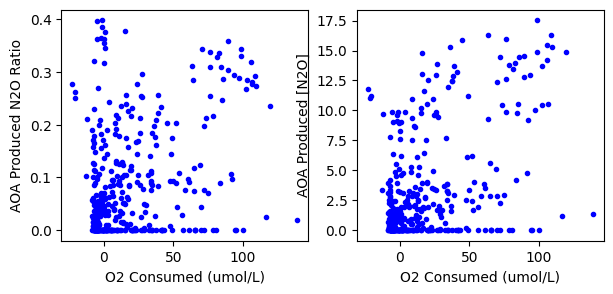

In [ ]:
# Consumed O2 vs Produced N2O Plots
consumed_o2 = np.array(o2_pre) - post_merge['OXYGEN'].astype(float)
fig, ax = plt.subplots(1, 2) # Make two plots
fig.set_size_inches(7, 3) # Size of the panel
fig.subplots_adjust(hspace = 0.5, wspace = 0.2) # Space between plots

ax[0].plot(consumed_o2, aoa_ratios, 'bo', markersize=3)  # Plot original points
ax[0].set_ylabel('AOA Produced N2O Ratio')
ax[0].set_xlabel('O2 Consumed (umol/L)')

n2o_obs = [float(num) for num in n2o_obs]
ax[1].plot(consumed_o2, (np.array(aoa_ratios) * n2o_obs), 'bo', markersize=3)  # Plot original points
ax[1].set_ylabel('AOA Produced [N2O]')
ax[1].set_xlabel('O2 Consumed (umol/L)')
plt.show()

# Export Model Results and Validation Results to Google Sheets

Lastly, because new data was generated through all of the above code, this section appends the new data onto the merged dataframe from the start as columns. Finally, this new dataframe is exported as a new tab to the main Google Sheet.

**Remember to change the name of the new tab to be created in the last line of this section, otherwise you will get an error because the tab already exists.**

In [ ]:
# Add all new data to growing dataframe (post_merge), export to Google Sheets at the end
n2o_obs = np.array(n2o_obs, dtype=np.float32)
post_merge['Preformed Conc'] = np.array(pre_ratios) * n2o_obs
post_merge['AOA Conc'] = np.array(aoa_ratios) * n2o_obs
post_merge['ID Conc'] = np.array(id_ratios) * n2o_obs
post_merge['ODZ Conc'] = np.array(cd_ratios) * n2o_obs
post_merge['Preformed d18O'] = d18O_pre
post_merge['Preformed d15Na'] = d15Na_pre
post_merge['Preformed d15Nb'] = d15Nb_pre
post_merge['Preformed O2'] = o2_pre
post_merge['Consumed O2'] = consumed_o2
post_merge['Preformed Ratio'] = pre_ratios
post_merge['AOA Ratio'] = aoa_ratios
post_merge['ID Ratio'] = id_ratios
post_merge['ODZ Ratio'] = cd_ratios
post_merge['Residual N2O'] = n2o_obs - (pre_ratios * n2o_obs + aoa_ratios * n2o_obs + id_ratios * n2o_obs + cd_ratios * n2o_obs)
post_merge['d18O Back Calc'] = d18O_backcalc
post_merge['d15Na Back Calc'] = d15Na_backcalc
post_merge['d15Nb Back Calc'] = d15Nb_backcalc
post_merge['d18O Back Calc Error'] = d18O_errors
post_merge['d15Na Back Calc Error'] = d15Na_errors
post_merge['d15Nb Back Calc Error'] = d15Nb_errors

# post_merge['Preformed Mean Stdev'] = pre_stdevs
# post_merge['AOA Mean Stdev'] = aoa_stdevs
# post_merge['ID Mean Stdev'] = id_stdevs
# post_merge['CD Mean Stdev'] = cd_stdevs

# post_merge['Preformed Ratio + Mean Stdev'] = pre_stdevs + pre_ratios
# post_merge['AOA Ratio + Mean Stdev'] = aoa_stdevs + aoa_ratios
# post_merge['ID Ratio + Mean Stdev'] = id_stdevs + id_ratios
# post_merge['CD Ratio + Mean Stdev'] = cd_stdevs + cd_ratios

# post_merge['Preformed Ratio - Mean Stdev'] = pre_ratios - pre_stdevs
# post_merge['AOA Ratio - Mean Stdev'] = aoa_ratios - aoa_stdevs
# post_merge['ID Ratio - Mean Stdev'] = id_ratios - id_stdevs
# post_merge['CD Ratio - Mean Stdev'] = cd_ratios - cd_stdevs

# #Change the sheet name to export
export_df_to_sheet(final_gp16_regression_model, '11 Final Product Colab', post_merge)


# Plotting Results
Plot of results to avoid ODV hassle


<ipython-input-23-d6937e009ad1>:21: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(-0.35,1.35,51,endpoint=True), extend="neither", cmap="rainbow", vmin=-0.35, vmax=1.35, fontsize=15)
<ipython-input-23-d6937e009ad1>:25: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
<ipython-input-23-d6937e009ad1>:21: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

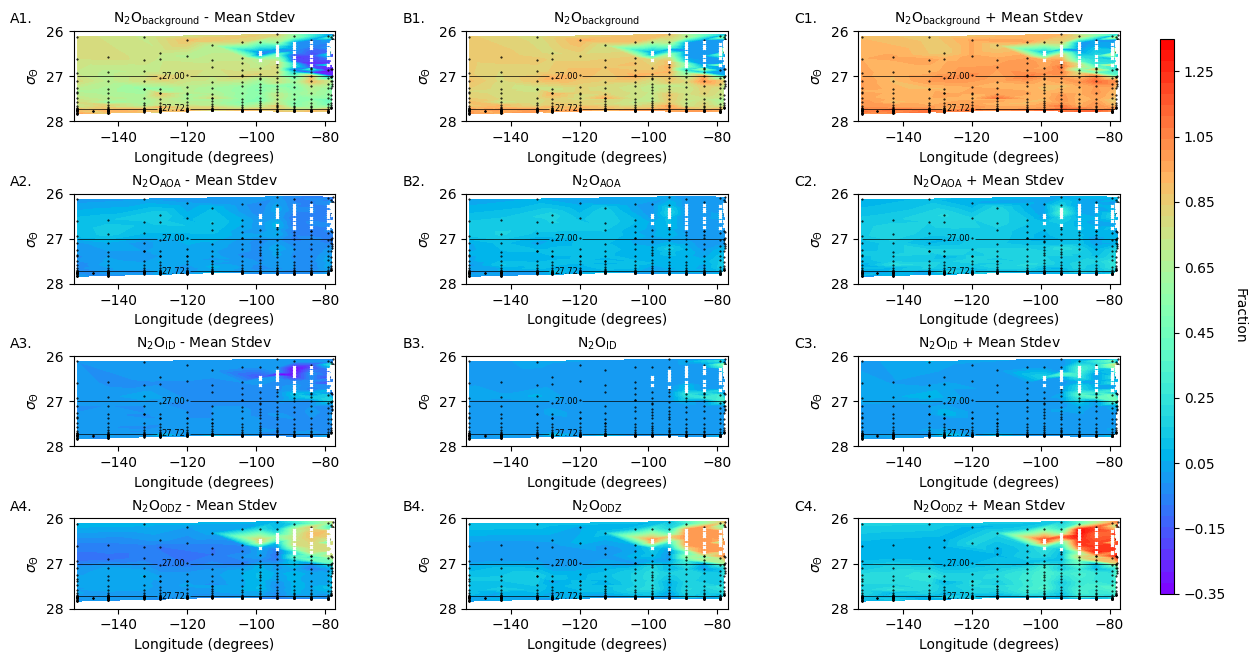

In [ ]:
# MAIN FIGURE IN PAPER
# Center is base case, two sides are base case +/- mean state
mc_sheet = import_sheet_as_df(final_gp16_regression_model, "10 Final Product Colab")
odz_n2o = mc_sheet[(mc_sheet['OXYGEN'].astype(float) < 5) & (mc_sheet['Potdens'].astype(float) > 26.2) & (mc_sheet['Potdens'].astype(float) < 26.8)]

from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# NORMALIZE DATA BEFORE TRIANGULATION
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(mc_sheet['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(mc_sheet['Potdens'].astype(float).values.reshape(-1,1))

triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def mc_plot(plot_name, variable, plot_row, plot_column):
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(-0.35,1.35,51,endpoint=True), extend="neither", cmap="rainbow", vmin=-0.35, vmax=1.35, fontsize=15)
  # colorbar = fig.colorbar(cntr2, ax=ax[plot_row,plot_column])
  # colorbar.ax.tick_params(labelsize=11)

  dens_cntr = ax[plot_row,plot_column].tricontour(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
  ax[plot_row,plot_column].plot(mc_sheet['LONGITUDE_x'].astype(float), mc_sheet['Potdens'].astype(float), 'ko', markersize=0.5)
  ax[plot_row,plot_column].plot(odz_n2o['LONGITUDE_x'].astype(float), odz_n2o['Potdens'].astype(float), 'wx', markersize=2)
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-124, 27), (-124, 27.72)])

  ax[plot_row,plot_column].set(xlim=(-153, -77), ylim=(26, 28))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=10)
  ax[plot_row, plot_column].set_ylabel(r"$\sigma_{\Theta}$", fontsize=10)
  ax[plot_row,plot_column].set_title(plot_name, fontsize = 10)
  return cntr2

fig, ax = plt.subplots(4, 3) # Make twelve plots
fig.set_size_inches(13.5, 7.5) # Size of the panel
fig.subplots_adjust(hspace = 0.8, wspace = 0.5) # Space between plots

mc_plot("$\mathrm{N_2O_{background}}$ - Mean Stdev", "Preformed Ratio - Mean Stdev", 0, 0)
mc_plot("$\mathrm{N_2O_{background}}$", "Preformed Ratio", 0, 1)
mc_plot("$\mathrm{N_2O_{background}}$ + Mean Stdev", "Preformed Ratio + Mean Stdev", 0, 2)

mc_plot("$\mathrm{N_2O_{AOA}}$ - Mean Stdev", "AOA Ratio - Mean Stdev", 1, 0)
mc_plot("$\mathrm{N_2O_{AOA}}$", "AOA Ratio", 1, 1)
mc_plot("$\mathrm{N_2O_{AOA}}$ + Mean Stdev", "AOA Ratio + Mean Stdev", 1, 2)

mc_plot("$\mathrm{N_2O_{ID}}$ - Mean Stdev", "ID Ratio - Mean Stdev", 2, 0)
mc_plot("$\mathrm{N_2O_{ID}}$", "ID Ratio", 2, 1)
mc_plot("$\mathrm{N_2O_{ID}}$ + Mean Stdev", "ID Ratio + Mean Stdev", 2, 2)

mc_plot("$\mathrm{N_2O_{ODZ}}$ - Mean Stdev", "CD Ratio - Mean Stdev", 3, 0)
mc_plot("$\mathrm{N_2O_{ODZ}}$", "ODZ Ratio", 3, 1)
cntr2_4 = mc_plot("$\mathrm{N_2O_{ODZ}}$ + Mean Stdev", "CD Ratio + Mean Stdev", 3, 2)

ax[0, 0].text(-0.2, 1.21, 'A1.', transform=ax[0, 0].transAxes, fontsize=10, va='top', ha='center')
ax[0, 1].text(-0.2, 1.21, 'B1.', transform=ax[0, 1].transAxes, fontsize=10, va='top', ha='center')
ax[0, 2].text(-0.2, 1.21, 'C1.', transform=ax[0, 2].transAxes, fontsize=10, va='top', ha='center')
ax[1, 0].text(-0.2, 1.21, 'A2.', transform=ax[1, 0].transAxes, fontsize=10, va='top', ha='center')
ax[1, 1].text(-0.2, 1.21, 'B2.', transform=ax[1, 1].transAxes, fontsize=10, va='top', ha='center')
ax[1, 2].text(-0.2, 1.21, 'C2.', transform=ax[1, 2].transAxes, fontsize=10, va='top', ha='center')
ax[2, 0].text(-0.2, 1.21, 'A3.', transform=ax[2, 0].transAxes, fontsize=10, va='top', ha='center')
ax[2, 1].text(-0.2, 1.21, 'B3.', transform=ax[2, 1].transAxes, fontsize=10, va='top', ha='center')
ax[2, 2].text(-0.2, 1.21, 'C3.', transform=ax[2, 2].transAxes, fontsize=10, va='top', ha='center')
ax[3, 0].text(-0.2, 1.21, 'A4.', transform=ax[3, 0].transAxes, fontsize=10, va='top', ha='center')
ax[3, 1].text(-0.2, 1.21, 'B4.', transform=ax[3, 1].transAxes, fontsize=10, va='top', ha='center')
ax[3, 2].text(-0.2, 1.21, 'C4.', transform=ax[3, 2].transAxes, fontsize=10, va='top', ha='center')

cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
ticks = np.arange(-0.35, 1.25 + 0.2, 0.2)
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=ticks)
colorbar.set_label(label="Fraction", fontsize=10, rotation=270, labelpad=15)

plt.savefig('04182025_3x4MonteCarlo.jpeg', dpi=2000)
files.download('04182025_3x4MonteCarlo.jpeg')

plt.show()

<ipython-input-27-6285db43fd22>:28: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(-0.12,0.12,51,endpoint=True), extend="neither", cmap="rainbow", vmin=-0.12, vmax=0.12, fontsize=15)
<ipython-input-27-6285db43fd22>:33: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['Potdens'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
<ipython-input-27-6285db43fd22>:28: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricon

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

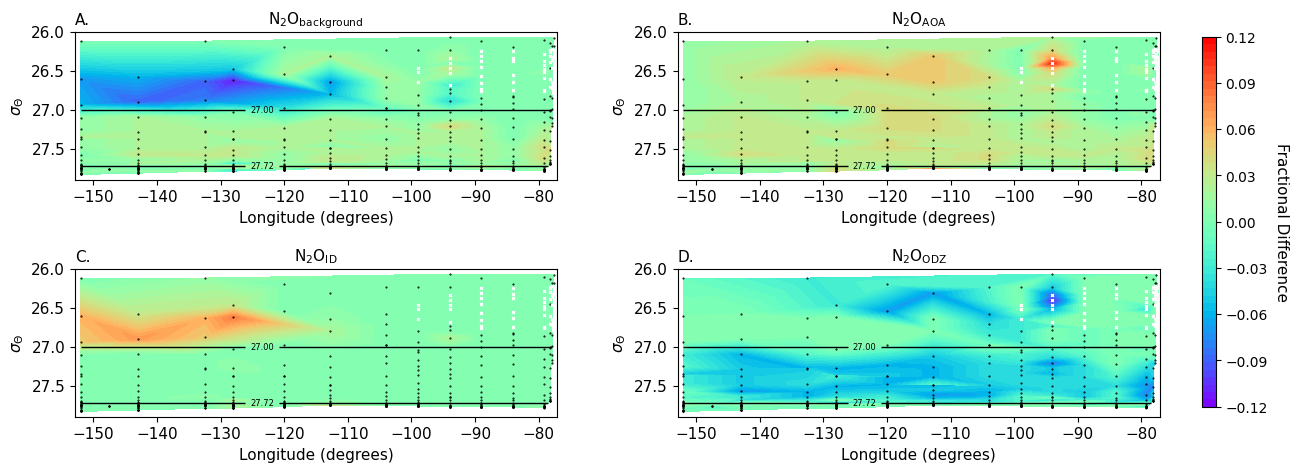

In [ ]:
# 4/12/2025 Difference between results when N2O_AOA-d18O = 34 versus N2O_AOA-d18O = 46
# If not re-running model and plotting N2O fractions (just pulls data from the compiled Google Sheet specified in next line)
post_merge = import_sheet_as_df(final_gp16_regression_model, "9 Final Product Colab")

# Four ODV Plots with potential density as the y-axis
# Import necessary packages and functions
from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Normalize longitude and depth data before triangulation
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(post_merge['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(post_merge['Potdens'].astype(float).values.reshape(-1,1))

# Create triangles that are later called in the plot line
triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def ratio_plot(plot_name, variable, plot_row, plot_column):
  '''
  Function that takes in the plot title, variable being plotted,
  and the position (row/column) of the specific subplot
  '''
  # Plot data
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(-0.12,0.12,51,endpoint=True), extend="neither", cmap="rainbow", vmin=-0.12, vmax=0.12, fontsize=15)
  ax[plot_row,plot_column].plot(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), 'ko', markersize=0.5)
  ax[plot_row,plot_column].plot(odz_n2o['LONGITUDE_x'].astype(float), odz_n2o['Potdens'].astype(float), 'wx', markersize=2)

  # Plot density contours
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['Potdens'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-123.5, 27), (-123.5, 27.72)])

  ax[plot_row,plot_column].set(xlim=(-152.9, -77.1), ylim=(26, 27.9))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=11)
  ax[plot_row, plot_column].set_ylabel(r"$\sigma_{\Theta}$", fontsize=11)
  ax[plot_row,plot_column].set_title(plot_name, fontsize = 11)
  ax[plot_row, plot_column].tick_params(axis='both', which='major', labelsize=11)
  return cntr2

# Make four plots
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14, 5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.25) # Space between plots

# Call the function four times for each plot
ratio_plot(r"$\mathrm{N_2O_{background}}$", "Diff Preformed (46 - 34)", 0, 0)
ratio_plot(r"$\mathrm{N_2O_{AOA}}$", "Diff AOA (46 - 34)", 0, 1)
ratio_plot(r"$\mathrm{N_2O_{ID}}$", "Diff ID Ratio (46 - 34)", 1, 0)
cntr2_4 = ratio_plot(r"$\mathrm{N_2O_{ODZ}}$", "Diff ODZ Ratio (46 - 34)", 1, 1)

# Place 'A.' above the top left subplot
ax[0, 0].text(0, 1.03, 'A.', transform=ax[0, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[0, 1].text(0, 1.03, 'B.', transform=ax[0, 1].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 0].text(0, 1.03, 'C.', transform=ax[1, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 1].text(0, 1.03, 'D.', transform=ax[1, 1].transAxes, fontsize=11, va='bottom', ha='left')

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=np.linspace(-0.12, 0.12, 9))
colorbar.set_label(label="Fractional Difference", fontsize=11, rotation=270, labelpad=15)

plt.savefig('04182025_46-34diff.jpeg', dpi=2000)
files.download('04182025_46-34diff.jpeg')

plt.show()


<ipython-input-11-e3d71c059710>:27: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,1.0000001,51,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=1.0000001, fontsize=15)
<ipython-input-11-e3d71c059710>:32: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['Potdens'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
<ipython-input-11-e3d71c059710>:27: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tric

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

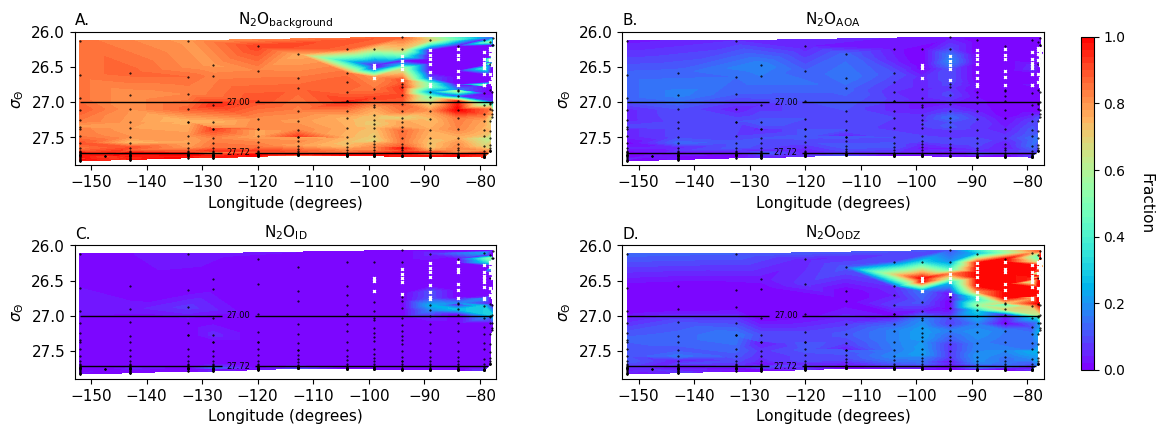

In [11]:
# Original 2 x 2 plot with the four end members and their respective fractions
# If not re-running model and plotting N2O fractions (just pulls data from the compiled Google Sheet specified in next line)
post_merge = import_sheet_as_df(final_gp16_regression_model, "10 Final Product Colab")

# Four ODV Plots with potential density as the y-axis
# Import necessary packages and functions
from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Normalize longitude and depth data before triangulation
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(post_merge['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(post_merge['Potdens'].astype(float).values.reshape(-1,1))

# Create triangles that are later called in the plot line
triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def ratio_plot(plot_name, variable, plot_row, plot_column):
  '''
  Function that takes in the plot title, variable being plotted,
  and the position (row/column) of the specific subplot
  '''
  # Plot data
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,1.0000001,51,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=1.0000001, fontsize=15)
  ax[plot_row,plot_column].plot(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), 'ko', markersize=0.5)
  ax[plot_row,plot_column].plot(odz_n2o['LONGITUDE_x'].astype(float), odz_n2o['Potdens'].astype(float), 'wx', markersize=2)

  # Plot density contours
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['Potdens'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-123.5, 27), (-123.5, 27.72)])

  ax[plot_row,plot_column].set(xlim=(-152.9, -77.1), ylim=(26, 27.9))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=11)
  ax[plot_row, plot_column].set_ylabel(r"$\sigma_{\Theta}$", fontsize=11)
  ax[plot_row,plot_column].set_title(plot_name, fontsize = 11)
  ax[plot_row, plot_column].tick_params(axis='both', which='major', labelsize=11)
  return cntr2

# Make four plots
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12.5, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.3) # Space between plots

# Call the function four times for each plot
ratio_plot(r"$\mathrm{N_2O_{background}}$", "Preformed Ratio", 0, 0)
ratio_plot(r"$\mathrm{N_2O_{AOA}}$", "AOA Ratio", 0, 1)
ratio_plot(r"$\mathrm{N_2O_{ID}}$", "ID Ratio", 1, 0)
cntr2_4 = ratio_plot(r"$\mathrm{N_2O_{ODZ}}$", "ODZ Ratio", 1, 1)

# Place 'A.' above the top left subplot
ax[0, 0].text(0, 1.03, 'A.', transform=ax[0, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[0, 1].text(0, 1.03, 'B.', transform=ax[0, 1].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 0].text(0, 1.03, 'C.', transform=ax[1, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 1].text(0, 1.03, 'D.', transform=ax[1, 1].transAxes, fontsize=11, va='bottom', ha='left')

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=np.linspace(0, 1, 6))
colorbar.set_label(label="Fraction", fontsize=11, rotation=270, labelpad=20)

plt.savefig('04242025_2x2basecase(AOA-d18O = 34).jpeg', dpi=2000)
files.download('04242025_2x2basecase(AOA-d18O = 34).jpeg')

plt.show()

<ipython-input-8-23fa9980e807>:27: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,80,51,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=80, fontsize=15)
<ipython-input-8-23fa9980e807>:32: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['Potdens'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
<ipython-input-8-23fa9980e807>:27: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

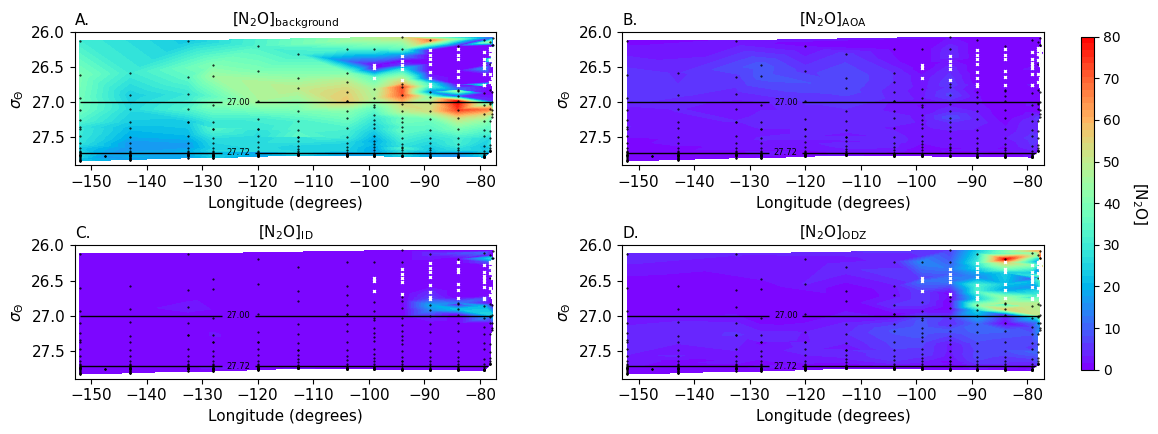

In [ ]:
# 2x2 Plot of four end members and their N2O concentrations instead of fractions
# Code uses data from Google Sheet specified in the next line
post_merge = import_sheet_as_df(final_gp16_regression_model, "10 Final Product Colab")

# Four ODV Plots with potential density as the y-axis
# Import necessary packages and functions
from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Normalize longitude and depth data before triangulation
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(post_merge['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(post_merge['Potdens'].astype(float).values.reshape(-1,1))

# Create triangles that are later called in the plot line
triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def ratio_plot(plot_name, variable, plot_row, plot_column):
  '''
  Function that takes in the plot title, variable being plotted,
  and the position (row/column) of the specific subplot
  '''
  # Plot data
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,80,51,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=80, fontsize=15)
  ax[plot_row,plot_column].plot(post_merge['LONGITUDE_x'].astype(float), post_merge['Potdens'].astype(float), 'ko', markersize=0.5)
  ax[plot_row,plot_column].plot(odz_n2o['LONGITUDE_x'].astype(float), odz_n2o['Potdens'].astype(float), 'wx', markersize=2)

  # Plot density contours
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['Potdens'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-123.5, 27), (-123.5, 27.72)])

  ax[plot_row,plot_column].set(xlim=(-152.9, -77.1), ylim=(26, 27.9))
  # ax[plot_row,plot_column].set(xlim=(np.min(post_merge['LONGITUDE_x'].astype(float)) - 0.5, np.max(post_merge['LONGITUDE_x'].astype(float))+ 0.5), ylim=(26, 27.9))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=11)
  ax[plot_row, plot_column].set_ylabel(r"$\sigma_{\Theta}$", fontsize=11)
  ax[plot_row,plot_column].set_title(plot_name, fontsize = 11)
  ax[plot_row, plot_column].tick_params(axis='both', which='major', labelsize=11)
  return cntr2

# Make four plots
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12.5, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.3) # Space between plots

# Call the function four times for each plot
ratio_plot(r"$\mathrm{[N_2O]_{background}}$", "Preformed Conc", 0, 0)
ratio_plot(r"$\mathrm{[N_2O]_{AOA}}$", "AOA Conc", 0, 1)
ratio_plot(r"$\mathrm{[N_2O]_{ID}}$", "ID Conc", 1, 0)
cntr2_4 = ratio_plot(r"$\mathrm{[N_2O]_{ODZ}}$", "ODZ Conc", 1, 1)

# Place 'A.' above the top left subplot
ax[0, 0].text(0, 1.03, 'A.', transform=ax[0, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[0, 1].text(0, 1.03, 'B.', transform=ax[0, 1].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 0].text(0, 1.03, 'C.', transform=ax[1, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 1].text(0, 1.03, 'D.', transform=ax[1, 1].transAxes, fontsize=11, va='bottom', ha='left')

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=np.linspace(0, 80, 9))
colorbar.set_label(label=r"$\mathrm{[N_2O]}$", fontsize=11, rotation=270, labelpad=20)

plt.savefig('04162025_meanstate.jpeg', dpi=2000)
files.download('04162025_meanstate.jpeg')

plt.show()

<ipython-input-20-2f61f40b48a9>:23: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(-0.35,1.35,51,endpoint=True), extend="neither", cmap="rainbow", vmin=-0.35, vmax=1.35, fontsize=15)
<ipython-input-20-2f61f40b48a9>:26: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
<ipython-input-20-2f61f40b48a9>:23: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

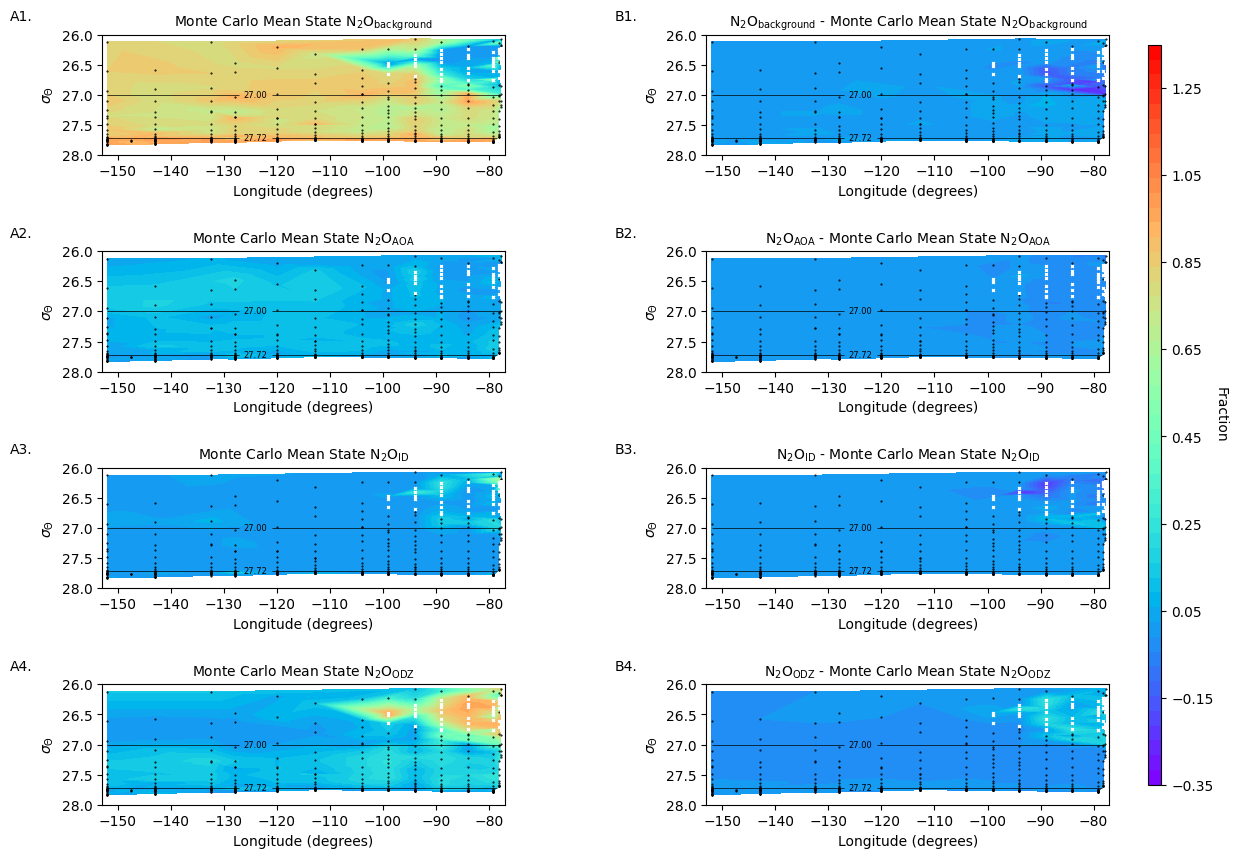

In [ ]:
# 4x2 Monte Carlo plots where left column is Monte Carlo mean state
# right column is the base case - monte carlo mean state
# Uses data from Google Sheet specified in next line
mc_sheet = import_sheet_as_df(final_gp16_regression_model, "10 Final Product Colab")
odz_n2o = mc_sheet[(mc_sheet['OXYGEN'].astype(float) < 5) & (mc_sheet['Potdens'].astype(float) > 26.2) & (mc_sheet['Potdens'].astype(float) < 26.8)]

from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# NORMALIZE DATA BEFORE TRIANGULATION
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(mc_sheet['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(mc_sheet['Potdens'].astype(float).values.reshape(-1,1))

triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def mc_plot(plot_name, variable, plot_row, plot_column):
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(-0.35,1.35,51,endpoint=True), extend="neither", cmap="rainbow", vmin=-0.35, vmax=1.35, fontsize=15)
  # colorbar = fig.colorbar(cntr2, ax=ax[plot_row,plot_column])

  dens_cntr = ax[plot_row,plot_column].tricontour(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
  ax[plot_row,plot_column].plot(mc_sheet['LONGITUDE_x'].astype(float), mc_sheet['Potdens'].astype(float), 'ko', markersize=0.5)
  ax[plot_row,plot_column].plot(odz_n2o['LONGITUDE_x'].astype(float), odz_n2o['Potdens'].astype(float), 'wx', markersize=2)
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-124, 27), (-124, 27.72)])

  ax[plot_row,plot_column].set(xlim=(-153, -77), ylim=(26, 28))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=10)
  ax[plot_row, plot_column].set_ylabel(r"$\sigma_{\Theta}$", fontsize=10)
  ax[plot_row,plot_column].set_title(plot_name, fontsize = 10)
  return cntr2

fig, ax = plt.subplots(4, 2) # Make twelve plots
fig.set_size_inches(13, 10) # Size of the panel
fig.subplots_adjust(hspace = 0.8, wspace = 0.5) # Space between plots

mc_plot(r"Monte Carlo Mean State $\mathrm{N_2O_{background}}$", "MC Mean Preformed Ratio", 0, 0)
mc_plot(r"$\mathrm{N_2O_{background}}$ - Monte Carlo Mean State $\mathrm{N_2O_{background}}$", "Pre Base Case - Mean State", 0, 1)

mc_plot(r"Monte Carlo Mean State $\mathrm{N_2O_{AOA}}$", "MC Mean AOA Ratio", 1, 0)
mc_plot(r"$\mathrm{N_2O_{AOA}}$ - Monte Carlo Mean State $\mathrm{N_2O_{AOA}}$", "AOA Base Case - Mean State", 1, 1)

mc_plot(r"Monte Carlo Mean State $\mathrm{N_2O_{ID}}$", "MC Mean ID Ratio", 2, 0)
mc_plot(r"$\mathrm{N_2O_{ID}}$ - Monte Carlo Mean State $\mathrm{N_2O_{ID}}$", "ID Base Case - Mean State", 2, 1)

mc_plot(r"Monte Carlo Mean State $\mathrm{N_2O_{ODZ}}$", "MC Mean CD Ratio", 3, 0)
cntr2_4 = mc_plot(r"$\mathrm{N_2O_{ODZ}}$ - Monte Carlo Mean State $\mathrm{N_2O_{ODZ}}$", "CD Base Case - Mean State", 3, 1)



ax[0, 0].text(-0.2, 1.21, 'A1.', transform=ax[0, 0].transAxes, fontsize=10, va='top', ha='center')
ax[0, 1].text(-0.2, 1.21, 'B1.', transform=ax[0, 1].transAxes, fontsize=10, va='top', ha='center')
ax[1, 0].text(-0.2, 1.21, 'A2.', transform=ax[1, 0].transAxes, fontsize=10, va='top', ha='center')
ax[1, 1].text(-0.2, 1.21, 'B2.', transform=ax[1, 1].transAxes, fontsize=10, va='top', ha='center')
ax[2, 0].text(-0.2, 1.21, 'A3.', transform=ax[2, 0].transAxes, fontsize=10, va='top', ha='center')
ax[2, 1].text(-0.2, 1.21, 'B3.', transform=ax[2, 1].transAxes, fontsize=10, va='top', ha='center')
ax[3, 0].text(-0.2, 1.21, 'A4.', transform=ax[3, 0].transAxes, fontsize=10, va='top', ha='center')
ax[3, 1].text(-0.2, 1.21, 'B4.', transform=ax[3, 1].transAxes, fontsize=10, va='top', ha='center')

cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
ticks = np.arange(-0.35, 1.25 + 0.2, 0.2)
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=ticks)
colorbar.set_label(label="Fraction", fontsize=10, rotation=270, labelpad=10)

plt.savefig('04162025_4x2Supp.jpeg', dpi=2000)
files.download('04162025_4x2Supp.jpeg')

plt.show()

# Additional Code/Scratch Code

<ipython-input-17-1afb8894e452>:24: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,1.0000001,51,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=1.0000001, fontsize=15)
<ipython-input-17-1afb8894e452>:29: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.5], colors = "black")
<ipython-input-17-1afb8894e452>:24: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].trico

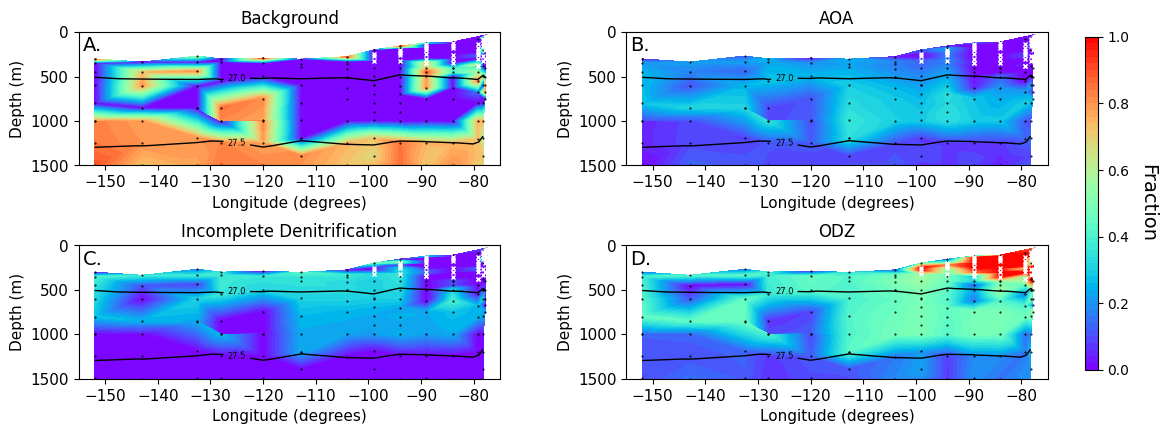

In [ ]:
# Four ODV Plots
# Import necessary packages and functions
from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Normalize longitude and depth data before triangulation
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(post_merge['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(post_merge['DEPTH_x'].astype(float).values.reshape(-1,1))

# Create triangles that are later called in the plot line
triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def ratio_plot(plot_name, variable, plot_row, plot_column):
  '''
  Function that takes in the plot title, variable being plotted,
  and the position (row/column) of the specific subplot
  '''
  # Plot data
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,1.0000001,51,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=1.0000001, fontsize=15)
  ax[plot_row,plot_column].plot(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), 'ko', markersize=0.5)
  ax[plot_row,plot_column].plot(odz_n2o['LONGITUDE_x'].astype(float), odz_n2o['DEPTH_x'].astype(float), 'wx', markersize=3)

  # Plot density contours
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.5], colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-125, 500), (-125, 1300)])

  ax[plot_row,plot_column].set(xlim=(-155, -75), ylim=(0, 1500))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=11)
  ax[plot_row,plot_column].set_ylabel("Depth (m)", fontsize = 11)
  ax[plot_row,plot_column].set_title(plot_name)
  ax[plot_row, plot_column].tick_params(axis='both', which='major', labelsize=11)
  return cntr2

# Make four plots
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12.5, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.3) # Space between plots

# Call the function four times for each plot
ratio_plot("Background", "Preformed Ratio", 0, 0)
ratio_plot("AOA", "AOA Ratio", 0, 1)
ratio_plot("Incomplete Denitrification", "ID Ratio", 1, 0)
cntr2_4 = ratio_plot("ODZ", "ODZ Ratio", 1, 1)

ax[0, 0].text(0.01, 0.97, 'A.', transform=ax[0, 0].transAxes, fontsize=14,  va='top', ha='left')
ax[0, 1].text(0.01, 0.97, 'B.', transform=ax[0, 1].transAxes, fontsize=14, va='top', ha='left')
ax[1, 0].text(0.01, 0.97, 'C.', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left')
ax[1, 1].text(0.01, 0.97, 'D.', transform=ax[1, 1].transAxes, fontsize=14,  va='top', ha='left')

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=np.linspace(0, 1, 6))
colorbar.set_label(label="Fraction", fontsize=14, rotation=270, labelpad=20)

# plt.savefig('11112024_IDSP0.jpeg', dpi=400)
# files.download('11112024_IDSP0.jpeg')

plt.show()


<ipython-input-20-83a3a8f89388>:27: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,1.0000001,51,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=1.0000001, fontsize=15)
<ipython-input-20-83a3a8f89388>:32: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['Potdens'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
<ipython-input-20-83a3a8f89388>:27: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tric

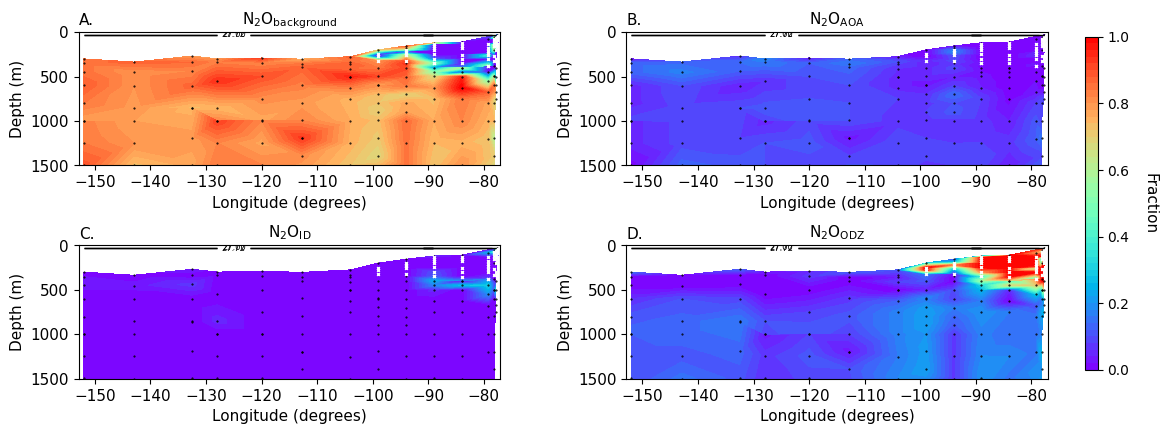

In [ ]:
# If not re-running model and fractions with depth as opposed to density
post_merge = import_sheet_as_df(final_gp16_regression_model, "9 Final Product Colab")

# Four ODV Plots with potential density as the y-axis
# Import necessary packages and functions
from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Normalize longitude and depth data before triangulation
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(post_merge['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(post_merge['DEPTH_x'].astype(float).values.reshape(-1,1))

# Create triangles that are later called in the plot line
triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def ratio_plot(plot_name, variable, plot_row, plot_column):
  '''
  Function that takes in the plot title, variable being plotted,
  and the position (row/column) of the specific subplot
  '''
  # Plot data
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,1.0000001,51,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=1.0000001, fontsize=15)
  ax[plot_row,plot_column].plot(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), 'ko', markersize=0.5)
  ax[plot_row,plot_column].plot(odz_n2o['LONGITUDE_x'].astype(float), odz_n2o['DEPTH_x'].astype(float), 'wx', markersize=2)

  # Plot density contours
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['Potdens'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-125, 500), (-125, 1300)])

  ax[plot_row,plot_column].set(xlim=(-152.9, -77.1), ylim=(0, 1500))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=11)
  ax[plot_row, plot_column].set_ylabel(r"Depth (m)", fontsize=11)
  ax[plot_row,plot_column].set_title(plot_name, fontsize = 11)
  ax[plot_row, plot_column].tick_params(axis='both', which='major', labelsize=11)
  return cntr2

# Make four plots
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12.5, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.3) # Space between plots

# Call the function four times for each plot
ratio_plot(r"$\mathrm{N_2O_{background}}$", "Preformed Ratio", 0, 0)
ratio_plot(r"$\mathrm{N_2O_{AOA}}$", "AOA Ratio", 0, 1)
ratio_plot(r"$\mathrm{N_2O_{ID}}$", "ID Ratio", 1, 0)
cntr2_4 = ratio_plot(r"$\mathrm{N_2O_{ODZ}}$", "ODZ Ratio", 1, 1)

# Place 'A.' above the top left subplot
ax[0, 0].text(0, 1.03, 'A.', transform=ax[0, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[0, 1].text(0, 1.03, 'B.', transform=ax[0, 1].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 0].text(0, 1.03, 'C.', transform=ax[1, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 1].text(0, 1.03, 'D.', transform=ax[1, 1].transAxes, fontsize=11, va='bottom', ha='left')

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=np.linspace(0, 1, 6))
colorbar.set_label(label="Fraction", fontsize=11, rotation=270, labelpad=20)

# plt.savefig('12202024_meanstate.jpeg', dpi=2000)
# files.download('12202024_meanstate.jpeg')

plt.show()

<ipython-input-12-fa919ac00f7f>:29: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['LONGITUDE_x'].astype(float), mc_sheet['Potdens'].astype(float), mc_sheet[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(-0.3,0.3,51,endpoint=True), extend="neither", cmap="rainbow", vmin=-0.3, vmax=0.3, fontsize=15)
<ipython-input-12-fa919ac00f7f>:34: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
<ipython-input-12-fa919ac00f7f>:29: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['

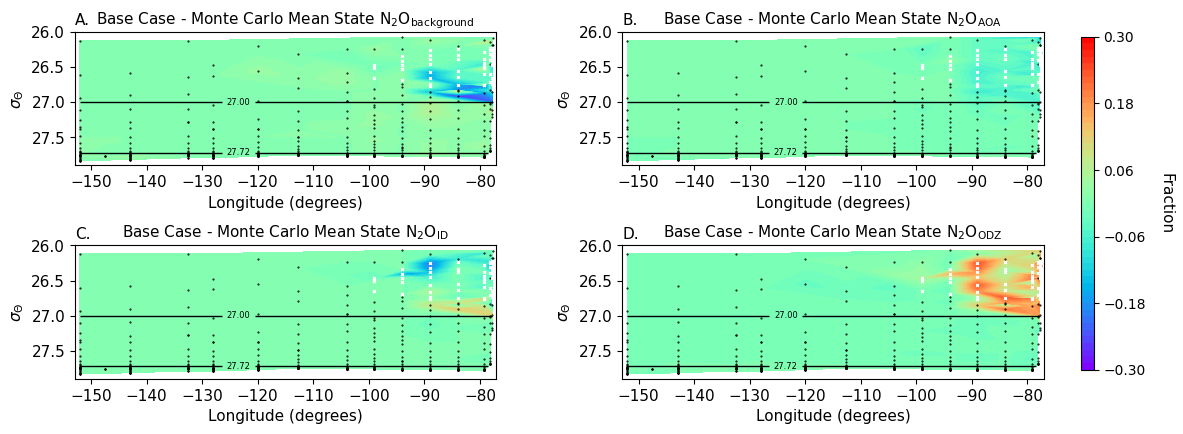

In [ ]:
# MODIFY TO BE DIFFERENCE BETWEEN MEAN OF MC AND BASE CASE
mc_sheet = import_sheet_as_df(final_gp16_regression_model, "8 Final Product Colab")
odz_n2o = mc_sheet[(mc_sheet['OXYGEN'].astype(float) < 5) & (mc_sheet['Potdens'].astype(float) > 26.2) & (mc_sheet['Potdens'].astype(float) < 26.8)]


# Four ODV Plots with potential density as the y-axis
# Import necessary packages and functions
from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Normalize longitude and depth data before triangulation
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(mc_sheet['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(mc_sheet['Potdens'].astype(float).values.reshape(-1,1))

# Create triangles that are later called in the plot line
triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def ratio_plot(plot_name, variable, plot_row, plot_column):
  '''
  Function that takes in the plot title, variable being plotted,
  and the position (row/column) of the specific subplot
  '''
  # Plot data
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['LONGITUDE_x'].astype(float), mc_sheet['Potdens'].astype(float), mc_sheet[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(-0.3,0.3,51,endpoint=True), extend="neither", cmap="rainbow", vmin=-0.3, vmax=0.3, fontsize=15)
  ax[plot_row,plot_column].plot(mc_sheet['LONGITUDE_x'].astype(float), mc_sheet['Potdens'].astype(float), 'ko', markersize=0.5)
  ax[plot_row,plot_column].plot(odz_n2o['LONGITUDE_x'].astype(float), odz_n2o['Potdens'].astype(float), 'wx', markersize=2)

  # Plot density contours
  dens_cntr = ax[plot_row,plot_column].tricontour(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['Potdens'].astype(float),mc_sheet['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[27, 27.72], colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-123.5, 27), (-123.5, 27.72)])

  ax[plot_row,plot_column].set(xlim=(-152.9, -77.1), ylim=(26, 27.9))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=11)
  ax[plot_row, plot_column].set_ylabel(r"$\sigma_{\Theta}$", fontsize=11)
  ax[plot_row,plot_column].set_title(plot_name, fontsize = 11)
  ax[plot_row, plot_column].tick_params(axis='both', which='major', labelsize=11)
  return cntr2

# Make four plots
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12.5, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.3) # Space between plots

# Call the function four times for each plot
ratio_plot(r"Base Case - Monte Carlo Mean State $\mathrm{N_2O_{background}}$", "Pre Base Case - Mean State", 0, 0)
ratio_plot(r"Base Case - Monte Carlo Mean State $\mathrm{N_2O_{AOA}}$", "AOA Base Case - Mean State", 0, 1)
ratio_plot(r"Base Case - Monte Carlo Mean State $\mathrm{N_2O_{ID}}$", "ID Base Case - Mean State", 1, 0)
cntr2_4 = ratio_plot(r"Base Case - Monte Carlo Mean State $\mathrm{N_2O_{ODZ}}$", "CD Base Case - Mean State", 1, 1)

# Place 'A.' above the top left subplot
ax[0, 0].text(0, 1.03, 'A.', transform=ax[0, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[0, 1].text(0, 1.03, 'B.', transform=ax[0, 1].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 0].text(0, 1.03, 'C.', transform=ax[1, 0].transAxes, fontsize=11, va='bottom', ha='left')
ax[1, 1].text(0, 1.03, 'D.', transform=ax[1, 1].transAxes, fontsize=11, va='bottom', ha='left')

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=np.linspace(-0.3, 0.3, 6))
colorbar.set_label(label="Fraction", fontsize=11, rotation=270, labelpad=20)

# plt.savefig('12202024_meanstate.jpeg', dpi=2000)
# files.download('12202024_meanstate.jpeg')

plt.show()

Text(0, 0.5, 'CD Ratio - Mean Stdev')

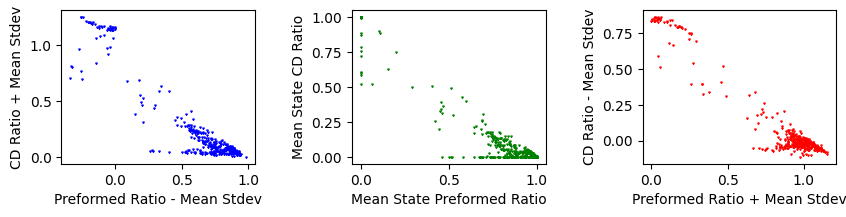

In [ ]:
# Plotting preformed ratios versus PC ratios to see if there is a clear trend
# Ratios versus Observed Data Plots
fig, ax = plt.subplots(1, 3) # Make two plots
fig.set_size_inches(10, 2) # Size of the panel
fig.subplots_adjust(hspace = 0.5, wspace = 0.5) # Space between plots


# Preformed vs PC for #11 Column H where PC is higher than average and Preformed is lower than average
ax[0].plot(mc_sheet['Preformed Ratio - Mean Stdev'].astype(float), mc_sheet['CD Ratio + Mean Stdev'].astype(float), 'b1', markersize=2)  # Plot original points
ax[0].set_xlabel('Preformed Ratio - Mean Stdev')
ax[0].set_ylabel('CD Ratio + Mean Stdev')

ax[1].plot(mc_sheet['Preformed Ratio'].astype(float), mc_sheet['CD Ratio'].astype(float), 'g1', markersize=2)  # Plot original points
ax[1].set_xlabel('Mean State Preformed Ratio')
ax[1].set_ylabel('Mean State CD Ratio')

ax[2].plot(mc_sheet['Preformed Ratio + Mean Stdev'].astype(float), mc_sheet['CD Ratio - Mean Stdev'].astype(float), 'r1', markersize=2)  # Plot original points
ax[2].set_xlabel('Preformed Ratio + Mean Stdev')
ax[2].set_ylabel('CD Ratio - Mean Stdev')

Text(0, 0.5, 'ID Ratio Column H')

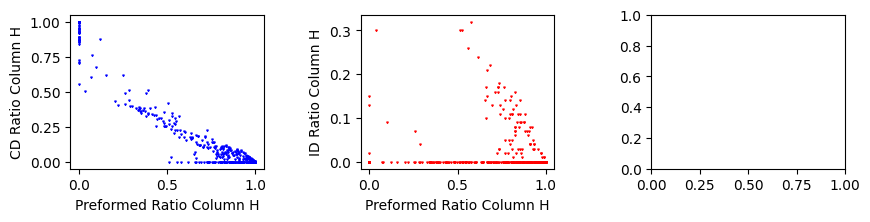

In [ ]:
fig, ax = plt.subplots(1, 3) # Make two plots
fig.set_size_inches(10, 2) # Size of the panel
fig.subplots_adjust(hspace = 0.5, wspace = 0.5) # Space between plots

pre_array_sheet = import_sheet_as_df(final_gp16_regression_model, "MC Pre Array 11")
cd_array_sheet = import_sheet_as_df(final_gp16_regression_model, "MC CD Array 11")
id_array_sheet = import_sheet_as_df(final_gp16_regression_model, "MC ID Array 11")

ax[0].plot(pre_array_sheet['Plot Pre Iteration Ratio'].astype(float), cd_array_sheet['Plot CD Iteration Ratio'].astype(float), 'b1', markersize=2)  # Plot original points
ax[0].set_xlabel('Preformed Ratio Column H')
ax[0].set_ylabel('CD Ratio Column H')

ax[1].plot(pre_array_sheet['Plot Pre Iteration Ratio'].astype(float), id_array_sheet['Plot ID Iteration Ratio'].astype(float), 'r1', markersize=2)  # Plot original points
ax[1].set_xlabel('Preformed Ratio Column H')
ax[1].set_ylabel('ID Ratio Column H')



<ipython-input-23-b12cf2d437bb>:25: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,80,41,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=80.000001, fontsize=15)
<ipython-input-23-b12cf2d437bb>:29: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[26.3, 27, 27.5], colors = "black")
<ipython-input-23-b12cf2d437bb>:25: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricon

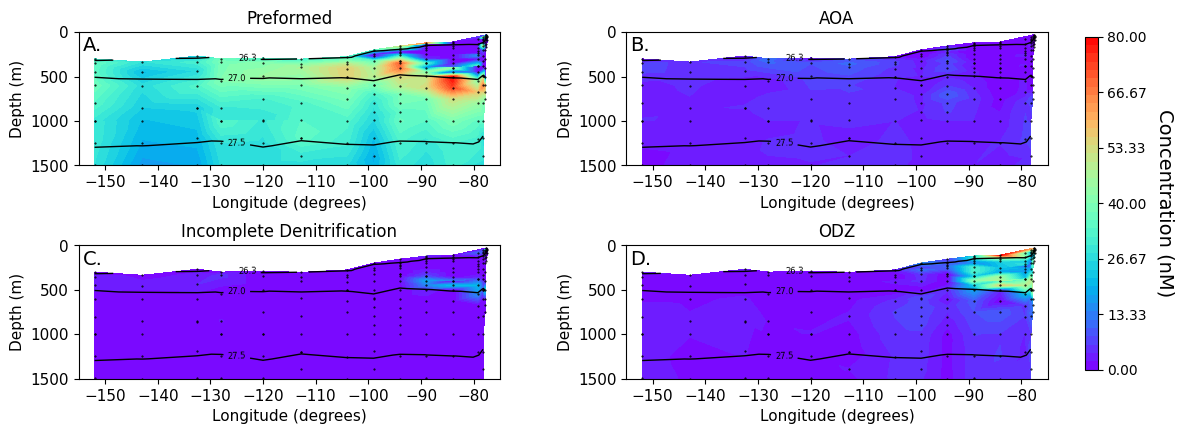

In [ ]:
# Four ODV Plots -- Plotting Actual [N2O] Concentrations

# Import necessary packages and functions
from matplotlib import tri
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Normalize longitude and depth data before triangulation
scaler = MinMaxScaler()
scaled_long = scaler.fit_transform(post_merge['LONGITUDE_x'].astype(float).values.reshape(-1,1))
scaled_depth = scaler.fit_transform(post_merge['DEPTH_x'].astype(float).values.reshape(-1,1))

# Create triangles that are later called in the plot line
triang=tri.Triangulation(scaled_long.flatten(), scaled_depth.flatten())
triang_analyze=tri.TriAnalyzer(triang)
mask=triang_analyze.get_flat_tri_mask()
triang.set_mask(mask)

def ratio_plot(plot_name, variable, plot_row, plot_column):
  '''
  Function that takes in the plot title, variable being plotted,
  and the position (row/column) of the specific subplot
  '''
  # Plot data
  cntr2 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,80,41,endpoint=True), extend="neither", cmap="rainbow", vmin=0, vmax=80.000001, fontsize=15)
  ax[plot_row,plot_column].plot(post_merge['LONGITUDE_x'].astype(float), post_merge['DEPTH_x'].astype(float), 'ko', markersize=0.5)

  # Plot density contours
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge['Potdens'].astype(float), linewidths=1.0, triangles=triang.triangles, mask=triang.mask,levels=[26.3, 27, 27.5], colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6, manual=[(-125, 250), (-125, 500), (-125, 1300)])

  ax[plot_row,plot_column].set(xlim=(-155, -75), ylim=(0, 1500))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=11)
  ax[plot_row,plot_column].set_ylabel("Depth (m)", fontsize = 11)
  ax[plot_row,plot_column].set_title(plot_name)
  ax[plot_row, plot_column].tick_params(axis='both', which='major', labelsize=11)
  return cntr2

# Make four plots
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12.5, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.3) # Space between plots

# Call the function four times for each plot
ratio_plot("Preformed", "Preformed Conc", 0, 0)
ratio_plot("AOA", "AOA Conc", 0, 1)
ratio_plot("Incomplete Denitrification", "ID Conc", 1, 0)
cntr2_4 = ratio_plot("ODZ", "ODZ Conc", 1, 1)

ax[0, 0].text(0.01, 0.97, 'A.', transform=ax[0, 0].transAxes, fontsize=14,  va='top', ha='left')
ax[0, 1].text(0.01, 0.97, 'B.', transform=ax[0, 1].transAxes, fontsize=14, va='top', ha='left')
ax[1, 0].text(0.01, 0.97, 'C.', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left')
ax[1, 1].text(0.01, 0.97, 'D.', transform=ax[1, 1].transAxes, fontsize=14,  va='top', ha='left')

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.13, 0.01, 0.74])
colorbar = fig.colorbar(cntr2_4, cax=cbar_ax, ticks=np.linspace(0, 80, 7))
colorbar.set_label(label="Concentration (nM)", fontsize=14, rotation=270, labelpad=20)

# plt.savefig('10082024_MeanState.jpeg', dpi=400)
# files.download('10082024_MeanState.jpeg')

plt.show()


<ipython-input-18-540dd8d67d22>:7: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['DEPTH_x'].astype(float),mc_sheet[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,0.5,51,endpoint=True), extend="both", cmap="rainbow", vmin=0, vmax=0.5, fontsize=15)
<ipython-input-18-540dd8d67d22>:11: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['DEPTH_x'].astype(float),mc_sheet['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=np.linspace(25,28,10,endpoint=True), colors = "black")
<ipython-input-18-540dd8d67d22>:7: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask', 'fontsize'
  cntr2 = ax[plot_row,plot_column].tricontourf

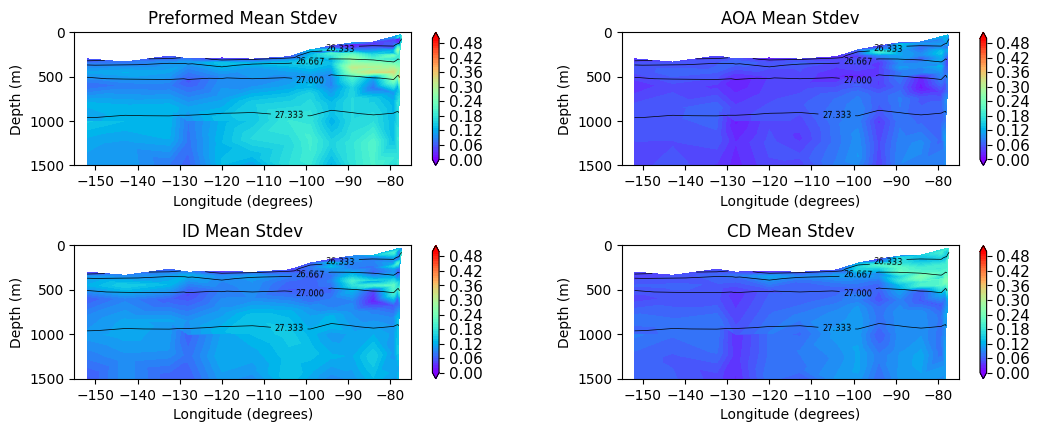

In [ ]:
# Plotting the Actual Standard Deviations
fig, ax = plt.subplots(2, 2) # Make four plots
fig.set_size_inches(12.5, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.3) # Space between plots

def stdev_plot(plot_name, variable, plot_row, plot_column):
  cntr2 = ax[plot_row,plot_column].tricontourf(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['DEPTH_x'].astype(float),mc_sheet[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,0.5,51,endpoint=True), extend="both", cmap="rainbow", vmin=0, vmax=0.5, fontsize=15)
  colorbar = fig.colorbar(cntr2, ax=ax[plot_row,plot_column])
  colorbar.ax.tick_params(labelsize=11)

  dens_cntr = ax[plot_row,plot_column].tricontour(mc_sheet['LONGITUDE_x'].astype(float),mc_sheet['DEPTH_x'].astype(float),mc_sheet['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=np.linspace(25,28,10,endpoint=True), colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=6)

  ax[plot_row,plot_column].set(xlim=(-155, -75), ylim=(0, 1500))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)", fontsize=10)
  ax[plot_row,plot_column].set_ylabel("Depth (m)", fontsize = 10)
  ax[plot_row,plot_column].set_title(plot_name)
  return cntr2

stdev_plot("Preformed Mean Stdev", "Preformed Mean Stdev", 0, 0)
stdev_plot("AOA Mean Stdev", "AOA Mean Stdev", 0,1)
stdev_plot("ID Mean Stdev", "ID Mean Stdev", 1,0)
stdev_plot("CD Mean Stdev", "CD Mean Stdev", 1,1)

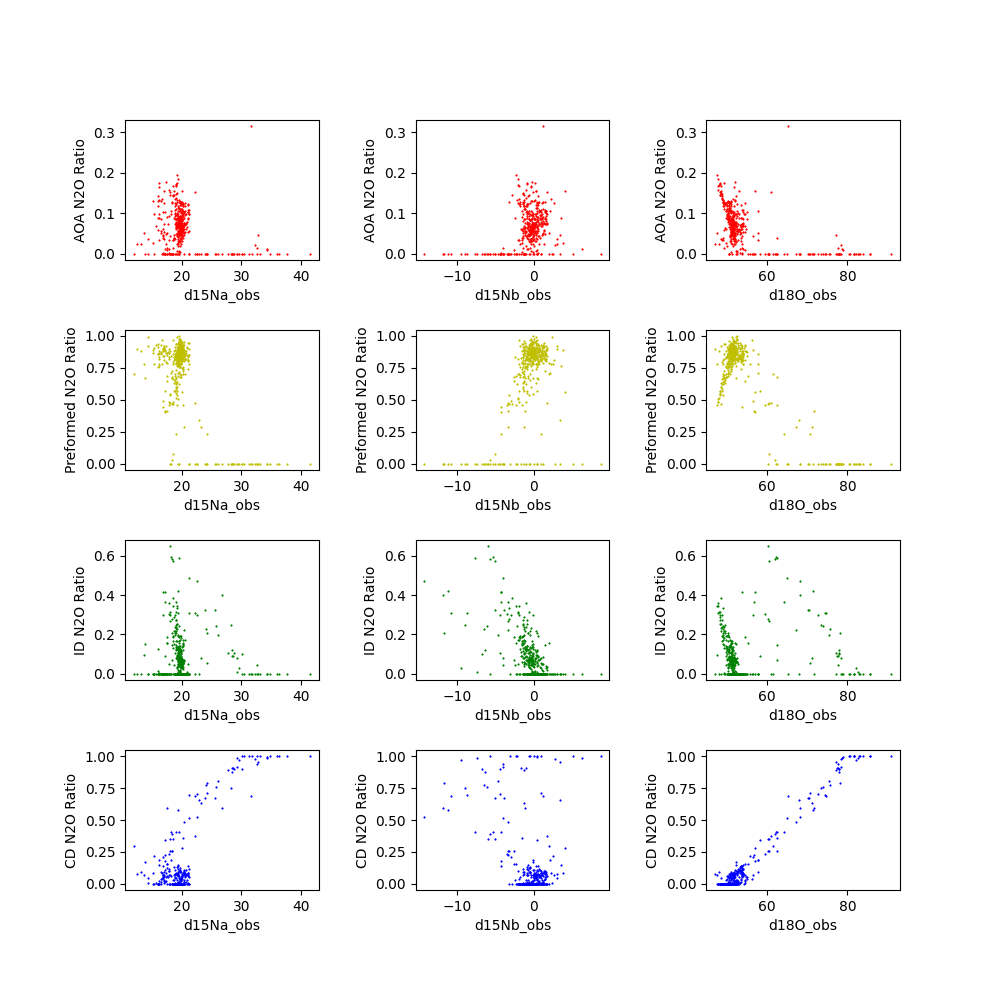

In [ ]:
# Ratios versus Observed Data Plots
fig, ax = plt.subplots(4, 3) # Make two plots
fig.set_size_inches(10, 10) # Size of the panel
fig.subplots_adjust(hspace = 0.5, wspace = 0.5) # Space between plots

# AOA
ax[0,0].plot(post_merge['alpha'].astype(float), post_merge['AOA Ratio'], 'r1', markersize=1.5)  # Plot original points
ax[0,0].set_ylabel('AOA N2O Ratio')
ax[0,0].set_xlabel('d15Na_obs')

ax[0,1].plot(post_merge['beta'].astype(float), post_merge['AOA Ratio'], 'r1', markersize=1.5)  # Plot original points
ax[0,1].set_ylabel('AOA N2O Ratio')
ax[0,1].set_xlabel('d15Nb_obs')

ax[0,2].plot(post_merge['d18o'].astype(float), post_merge['AOA Ratio'], 'r1', markersize=1.5)  # Plot original points
ax[0,2].set_ylabel('AOA N2O Ratio')
ax[0,2].set_xlabel('d18O_obs')

# Preformed
ax[1,0].plot(post_merge['alpha'].astype(float), post_merge['Preformed Ratio'], 'y1', markersize=1.5)  # Plot original points
ax[1,0].set_ylabel('Preformed N2O Ratio')
ax[1,0].set_xlabel('d15Na_obs')

ax[1,1].plot(post_merge['beta'].astype(float), post_merge['Preformed Ratio'], 'y1', markersize=1.5)  # Plot original points
ax[1,1].set_ylabel('Preformed N2O Ratio')
ax[1,1].set_xlabel('d15Nb_obs')

ax[1,2].plot(post_merge['d18o'].astype(float), post_merge['Preformed Ratio'], 'y1', markersize=1.5)  # Plot original points
ax[1,2].set_ylabel('Preformed N2O Ratio')
ax[1,2].set_xlabel('d18O_obs')

# ID
ax[2,0].plot(post_merge['alpha'].astype(float), post_merge['ID Ratio'], 'g1', markersize=1.5)  # Plot original points
ax[2,0].set_ylabel('ID N2O Ratio')
ax[2,0].set_xlabel('d15Na_obs')

ax[2,1].plot(post_merge['beta'].astype(float), post_merge['ID Ratio'], 'g1', markersize=1.5)  # Plot original points
ax[2,1].set_ylabel('ID N2O Ratio')
ax[2,1].set_xlabel('d15Nb_obs')

ax[2,2].plot(post_merge['d18o'].astype(float), post_merge['ID Ratio'], 'g1', markersize=1.5)  # Plot original points
ax[2,2].set_ylabel('ID N2O Ratio')
ax[2,2].set_xlabel('d18O_obs')

# CD
ax[3,0].plot(post_merge['alpha'].astype(float), post_merge['CD Ratio'], 'b1', markersize=1.5)  # Plot original points
ax[3,0].set_ylabel('CD N2O Ratio')
ax[3,0].set_xlabel('d15Na_obs')

ax[3,1].plot(post_merge['beta'].astype(float), post_merge['CD Ratio'], 'b1', markersize=1.5)  # Plot original points
ax[3,1].set_ylabel('CD N2O Ratio')
ax[3,1].set_xlabel('d15Nb_obs')

ax[3,2].plot(post_merge['d18o'].astype(float), post_merge['CD Ratio'], 'b1', markersize=1.5)  # Plot original points
ax[3,2].set_ylabel('CD N2O Ratio')
ax[3,2].set_xlabel('d18O_obs')
plt.show()

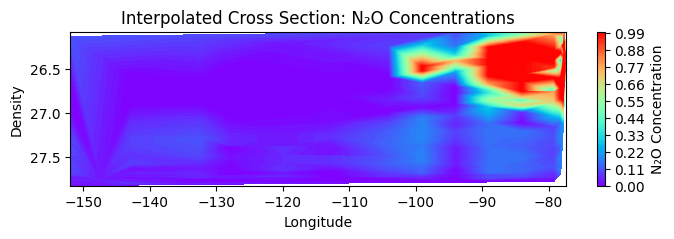

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Load your CSV file
# Replace 'your_file.csv' with the path to your file
data = import_sheet_as_df(final_gp16_regression_model, "5 Final Product Colab")

# Extract columns
longitude = data['LONGITUDE_x'].astype(float)
density = data['Potdens'].astype(float)
n2o_concentration = data['ODZ Ratio'].astype(float)

# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(longitude.min(), longitude.max(), 500),  # Fine grid for longitude
    np.linspace(density.min(), density.max(), 500)      # Fine grid for density
)

# Interpolate N₂O concentrations onto the grid
grid_z = griddata(
    (longitude, density), n2o_concentration,
    (grid_x, grid_y),
    method='linear'  # You can try 'cubic' for smoother results
)

# Plotting
plt.figure(figsize=(8, 2))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='rainbow')
plt.colorbar(contour, label='N₂O Concentration')
plt.gca().invert_yaxis()  # Invert the y-axis to have density increase downwards

# Add labels and title
plt.title('Interpolated Cross Section: N₂O Concentrations')
plt.xlabel('Longitude')
plt.ylabel('Density')

# Show the plot
plt.show()


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()
!pip install ipympl
%matplotlib ipympl

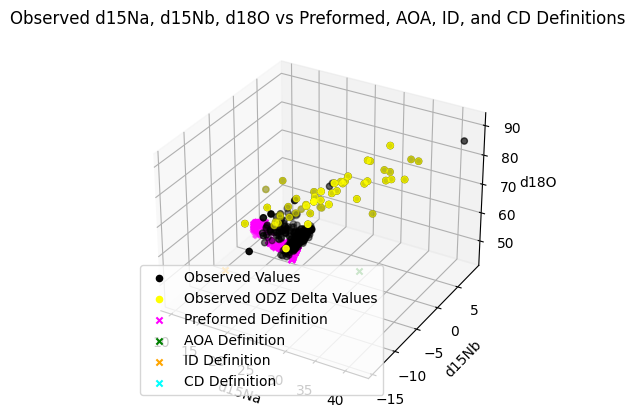

In [ ]:
# Raw data plotted in end member space
plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(post_merge["alpha"].astype(float), post_merge["beta"].astype(float), post_merge["d18o"].astype(float),marker='o', color ="black",
              label='Observed Values')

ax.scatter3D(odz_n2o["alpha"].astype(float), odz_n2o["beta"].astype(float), odz_n2o["d18o"].astype(float), marker='o',
               color="yellow",
               label='Observed ODZ Delta Values')
# ax.scatter3D(D15NA_PRE, D15NB_PRE, D18O_PRE, marker='x',
#               color="magenta", label='Preformed Definition')
ax.scatter3D(post_merge["Preformed d15Na"].astype(float), post_merge["Preformed d15Nb"].astype(float), post_merge["Preformed d18O"].astype(float), marker='x',
               color="magenta", label='Preformed Definition')
ax.scatter3D(D15NA_AOA, D15NB_AOA, D18O_AOA, color='green', marker='x', label='AOA Definition')
ax.scatter3D(D15NA_ID, D15NB_ID, D18O_ID, color='orange', marker='x', label='ID Definition')
ax.scatter3D(D15NA_CD, D15NB_CD, D18O_CD, color='cyan', marker='x', label='CD Definition')
ax.set_xlabel('d15Na')
ax.set_ylabel('d15Nb')
ax.set_zlabel('d18O')
plt.title("Observed d15Na, d15Nb, d18O vs Preformed, AOA, ID, and CD Definitions")
plt.legend(loc='lower left')
plt.show()


In [ ]:
def four_endmember_montecarlo(n, post_merge,
                              D18O_AOA, D18O_AOA_SD, D15NA_AOA, D15NA_AOA_SD, D15NB_AOA, D15NB_AOA_SD,
                              D18O_ID, D18O_ID_SD, D15N_NO3, D15N_NO3_SD,
                              D18O_CD, D18O_CD_SD, D15NA_CD, D15NA_CD_SD, D15NB_CD, D15NB_CD_SD):
  # Create four empty arrays to hold the columns of results for each iteration (dimensions 404 x 0)
  pre_array = np.empty((len(post_merge["n2o_nm"]), 0))
  aoa_array = np.empty((len(post_merge["n2o_nm"]), 0))
  id_array = np.empty((len(post_merge["n2o_nm"]), 0))
  cd_array = np.empty((len(post_merge["n2o_nm"]), 0))

  # Three 1 x (n+1) arrays to hold each perturbed ID N2O definition
  d18o_id_perturb = np.random.normal(D18O_ID, D18O_ID_SD, n)
  d15n_no3_perturb = np.random.normal(D15N_NO3, D15N_NO3_SD, n)

  d15na_id_perturb = d15n_no3_perturb - 0
  d15nb_id_perturb = d15n_no3_perturb - 22

  # Three 1 x (n+1) arrays to hold each perturbed CD N2O definition
  d18o_cd_perturb = np.random.normal(D18O_CD, D18O_CD_SD, n)
  d15na_cd_perturb = np.random.normal(D15NA_CD, D15NA_CD_SD, n)
  d15nb_cd_perturb = np.random.normal(D15NB_CD, D15NB_CD_SD, n)

  ratios = pd.DataFrame(columns = ['Preformed Ratio', 'AOA Ratio', 'ID Ratio', 'CD Ratio'])

  # Monte Carlo For Loop
  for i in range(n):
    # To store the results from this specific iteration
    pre_array_column_i = []
    aoa_array_column_i = []
    id_array_column_i = []
    cd_array_column_i = []

    # Looping through all the samples for one Monte Carlo iteration
    for samp_num in range(len(post_merge["n2o_nm"])):
      A = np.array([[d15Na_pre[samp_num], D15NA_AOA, d15na_id_perturb[i], d15na_cd_perturb[i]],
                    [d15Nb_pre[samp_num], D15NB_AOA, d15nb_id_perturb[i], d15nb_cd_perturb[i]],
                    [d18O_pre[samp_num], D18O_AOA, d18o_id_perturb[i], d18o_cd_perturb[i]]])
      b = np.array([d15Na_obs[samp_num], d15Nb_obs[samp_num], d18O_obs[samp_num]])

      x = cp.Variable(4, nonneg=True) # Number of coefficients, also equal to number of rows in A
      objective = cp.Minimize(cp.sum_squares(A @ x-b)) # Minimizes the sum of the squares to optimize the coefficient guess
      constraints = [cp.sum(x) == 1] # Constrains the coefficient predictions to be >= 0 and sum to 1
      prob  = cp.Problem(objective, constraints)
      result = prob.solve(solver='CLARABEL')

      # Add the new result to their respective arrays
      pre_array_column_i = np.append(pre_array_column_i, x.value[0])
      aoa_array_column_i = np.append(aoa_array_column_i, x.value[1])
      id_array_column_i = np.append(id_array_column_i, x.value[2])
      cd_array_column_i = np.append(cd_array_column_i, x.value[3])

    # Adds new column of results onto growing array
    pre_array = np.column_stack((pre_array, pre_array_column_i))
    aoa_array = np.column_stack((aoa_array, aoa_array_column_i))
    id_array = np.column_stack((id_array, id_array_column_i))
    cd_array = np.column_stack((cd_array, cd_array_column_i))

  # print(pre_array)
  # print("\n" f"D18O ID Perturb: {d18o_id_perturb}")
  # print("\n" f"D15NA ID Perturb: {d15na_id_perturb}")
  # print("\n" f"D15NB ID Perturb: {d15nb_id_perturb}")

  # print("\n" f"D18O CD Perturb: {d18o_cd_perturb}")
  # print("\n" f"D15NA CD Perturb: {d15na_cd_perturb}")
  # print("\n" f"D15NB CD Perturb: {d15nb_cd_perturb}")

  # Change the sheet name to export
  export_df_to_sheet(final_gp16_regression_model, 'MC Pre Array 11', pd.DataFrame(pre_array, columns=["Pre Iteration Ratio"] * (n)))
  export_df_to_sheet(final_gp16_regression_model, 'MC AOA Array 11', pd.DataFrame(aoa_array, columns=["AOA Iteration Ratio"] * (n)))
  export_df_to_sheet(final_gp16_regression_model, 'MC ID Array 11', pd.DataFrame(id_array, columns=["ID Iteration Ratio"] * (n)))
  export_df_to_sheet(final_gp16_regression_model, 'MC CD Array 11', pd.DataFrame(cd_array, columns=["CD Iteration Ratio"] * (n)))

  pre_stdevs = np.std(pre_array, axis = 1)
  aoa_stdevs = np.std(aoa_array, axis = 1)
  id_stdevs = np.std(id_array, axis = 1)
  cd_stdevs = np.std(cd_array, axis = 1)

  pre_array_stdev = np.mean(pre_stdevs)
  aoa_array_stdev = np.mean(aoa_stdevs)
  id_array_stdev = np.mean(id_stdevs)
  cd_array_stdev = np.mean(cd_stdevs)

  # print("\n" f"Mean Preformed Ratio Standard Deviation: {pre_array_stdev}")
  # print("\n" f"Mean AOA Ratio Standard Deviation: {aoa_array_stdev}")
  # print("\n" f"Mean Incomplete Denitrification Standard Deviation: {id_array_stdev}")
  # print("\n" f"Mean Complete Denitrification Standard Deviation: {cd_array_stdev}")

  return pre_stdevs, aoa_stdevs, id_stdevs, cd_stdevs, pre_array_stdev, aoa_array_stdev, id_array_stdev, cd_array_stdev

In [ ]:
# Plotting the parameter distributions
# ID and CD Histograms
from scipy.stats import norm
fig, ax = plt.subplots(2, 3) # Make two plots
fig.set_size_inches(7, 5) # Size of the panel
fig.subplots_adjust(hspace = 0.5, wspace = 0.7) # Space between plots
x = np.linspace (50, 90, 300)

# D18O CD
ax[0,0].hist(odz_n2o['d18o'].astype(float), bins=30, color='skyblue', edgecolor='black', density=True)
x1 = np.linspace (50, 90, 300)
ax[0,0].plot(x1, norm.pdf(x1, D18O_CD, D18O_SD_CD), 'r-')
ax[0,0].set_ylabel('P(d18O N2O CD)')
ax[0,0].set_xlabel('d18O N2O CD (permille)')

# D15NA CD
ax[0,1].hist(odz_n2o['alpha'].astype(float), bins=30, color='green', edgecolor='black', density=True)
x2 = np.linspace (5, 40, 300)
ax[0,1].plot(x2, norm.pdf(x2, D15NA_CD, D15NA_SD_CD), 'r-')
ax[0,1].set_ylabel('P(d15NA N2O CD)')
ax[0,1].set_xlabel('d15NA N2O CD (permille)')

# D15NB CD
ax[0,2].hist(odz_n2o['beta'].astype(float), bins=30, color='yellow', edgecolor='black', density=True)
x3 = np.linspace (-13, 10, 300)
ax[0,2].plot(x3, norm.pdf(x3, D15NB_CD, D15NB_SD_CD), 'r-')
ax[0,2].set_ylabel('P(d15NB N2O CD)')
ax[0,2].set_xlabel('d15NB N2O CD (permille)')

# D18O NO3
ax[1,0].hist(odz_no3['d18O-NO3 AVG (FINAL)'].astype(float), bins=30, color='skyblue', edgecolor='black', density=True)
x4 = np.linspace (-5, 32, 300)
ax[1,0].plot(x4, norm.pdf(x4, D18O_NO3, D18O_NO3_SD), 'r-')
ax[1,0].set_ylabel('P(d18O ODZ NO3)')
ax[1,0].set_xlabel('d18O ODZ NO3 (permille)')

# D15N NO3
ax[1,1].hist(odz_no3['d15N-NO3 AVG (FINAL)'].astype(float), bins=30, color='purple', edgecolor='black', density=True)
x5 = np.linspace (0, 40, 300)
ax[1,1].plot(x5, norm.pdf(x5, D15N_NO3, D15N_NO3_SD), 'r-')
ax[1,1].set_ylabel('P(d15N ODZ NO3)')
ax[1,1].set_xlabel('d15N ODZ NO3 (permille)')

plt.show()

<ipython-input-37-03b7c44bb649>:3: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  cntr4 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,75,26,endpoint=True), extend="both", cmap="rainbow", vmin=0, vmax=75)
<ipython-input-37-03b7c44bb649>:6: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=np.linspace(25,28,10,endpoint=True), colors = "black")


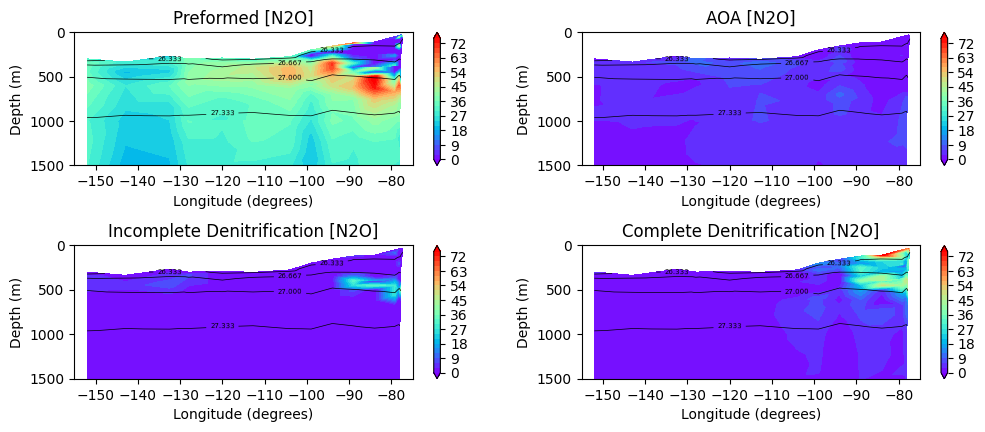

In [ ]:
# Concentration Plots
def conc_plot(plot_name, variable, plot_row, plot_column):
  cntr4 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(0,75,26,endpoint=True), extend="both", cmap="rainbow", vmin=0, vmax=75)
  fig.colorbar(cntr4, ax=ax[plot_row,plot_column])

  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=np.linspace(25,28,10,endpoint=True), colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=5)

  ax[plot_row,plot_column].set(xlim=(-155, -75), ylim=(0, 1500))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)")
  ax[plot_row,plot_column].set_ylabel("Depth (m)")
  ax[plot_row,plot_column].set_title(plot_name)

fig, ax = plt.subplots(2, 2) # Make four plots
fig.set_size_inches(12, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.2) # Space between plots

conc_plot("Preformed [N2O]", "Preformed Conc", 0, 0)
conc_plot("AOA [N2O]", "AOA Conc", 0, 1)
conc_plot("Incomplete Denitrification [N2O]", "ID Conc", 1, 0)
conc_plot("Complete Denitrification [N2O]", "CD Conc", 1, 1)

plt.show()

<ipython-input-46-64a82c4a93ea>:3: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  cntr4 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(min,max,26,endpoint=True), extend="both", cmap="rainbow", vmin= min, vmax=max)
<ipython-input-46-64a82c4a93ea>:6: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'
  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=np.linspace(25,28,10,endpoint=True), colors = "black")


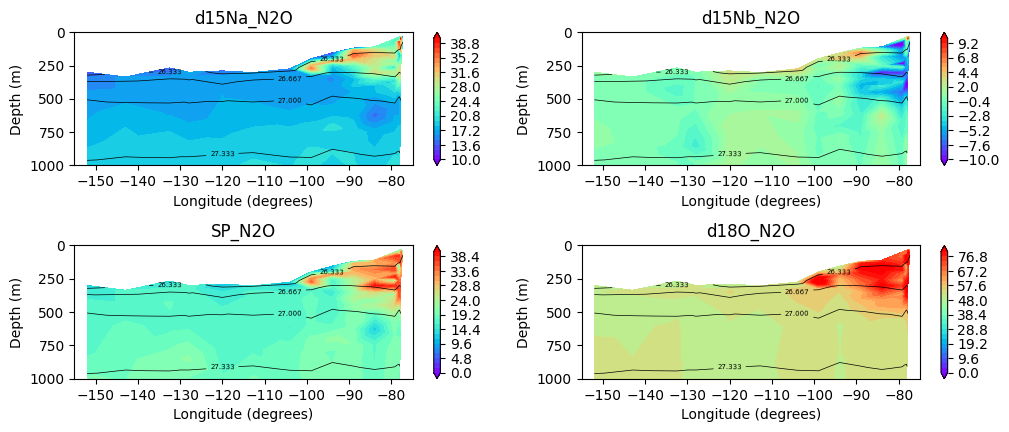

In [ ]:
# Original Data Plots
def data_plot(plot_name, variable, plot_row, plot_column, min, max):
  cntr4 = ax[plot_row,plot_column].tricontourf(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge[variable].astype(float), triangles=triang.triangles, mask=triang.mask,levels=np.linspace(min,max,26,endpoint=True), extend="both", cmap="rainbow", vmin= min, vmax=max)
  fig.colorbar(cntr4, ax=ax[plot_row,plot_column])

  dens_cntr = ax[plot_row,plot_column].tricontour(post_merge['LONGITUDE_x'].astype(float),post_merge['DEPTH_x'].astype(float),post_merge['Potdens'].astype(float), linewidths=0.5, triangles=triang.triangles, mask=triang.mask,levels=np.linspace(25,28,10,endpoint=True), colors = "black")
  ax[plot_row,plot_column].clabel(dens_cntr, inline=True, fontsize=5)

  ax[plot_row,plot_column].set(xlim=(-155, -75), ylim=(0, 1000))
  ax[plot_row,plot_column].invert_yaxis()
  ax[plot_row,plot_column].set_xlabel("Longitude (degrees)")
  ax[plot_row,plot_column].set_ylabel("Depth (m)")
  ax[plot_row,plot_column].set_title(plot_name)

fig, ax = plt.subplots(2, 2) # Make four plots
fig.set_size_inches(12, 4.5) # Size of the panel
fig.subplots_adjust(hspace = 0.6, wspace = 0.2) # Space between plots

data_plot("d15Na_N2O", "alpha", 0, 0, 10, 40)
data_plot("d15Nb_N2O", "beta", 0, 1, -10, 10)
data_plot("SP_N2O", "sp", 1, 0, 0, 40)
data_plot("d18O_N2O", "d18o", 1, 1, 0, 80)

plt.show()

Merging of Google Sheets and Google Colab done following the instructions and code in this blog: https://medium.com/mlearning-ai/how-to-access-google-sheets-on-google-colaboratory-8766b3a0996f

In [ ]:
# CODE FOR TESTING DIFFERENT SOLVERS

e_ratios = pd.DataFrame(columns = ['Preformed Ratio', 'AOA Ratio', 'ID Ratio', 'CD Ratio'])

for i in range(len(n2o_obs)):
  A = np.array([[d15Na_pre[i], D15NA_AOA, D15NA_ID, D15NA_CD], [d15Nb_pre[i], D15NB_AOA, D15NB_ID, D15NB_CD], [d18O_pre[i], D18O_AOA, D18O_ID, D18O_CD]])
  b = np.array([d15Na_obs[i], d15Nb_obs[i], d18O_obs[i]])

  x = cp.Variable(4, nonneg=True) # Number of coefficients that are being guessed, also equal to number of rows in A
  objective = cp.Minimize(cp.sum_squares(A @ x-b)) # Minimizes the sum of the squares to optimize the coefficient guess
  constraints = [cp.sum(x) == 1] # Constrains the coefficient predictions to be >= 0 and sum to 1
  prob  = cp.Problem(objective, constraints)
  result = prob.solve(solver='CLARABEL')

  ratios_to_df = pd.DataFrame([x.value], columns = e_ratios.columns)
  e_ratios = e_ratios.append(ratios_to_df, ignore_index=True) # Appends new sample onto dataframe

print(e_ratios) # The ratios variable holds the result

<ipython-input-16-f4c9e0697ca6>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  e_ratios = e_ratios.append(ratios_to_df, ignore_index=True) # Appends new sample onto dataframe


     Preformed Ratio     AOA Ratio      ID Ratio  CD Ratio
0       1.261375e-12  2.313750e-11  2.145869e-01  0.785413
1       4.290854e-11  1.168011e-10  4.232076e-11  1.000000
2       1.758374e-10  5.654737e-10  2.597459e-10  1.000000
3       8.554106e-13  1.135900e-02  8.332512e-10  0.988641
4       4.748552e-10  2.594498e-08  1.186509e-01  0.881349
..               ...           ...           ...       ...
398     8.978710e-01  4.498889e-02  2.862833e-02  0.028512
399     9.967355e-01  3.825033e-11  3.153814e-03  0.000111
400     8.852811e-01  2.031090e-02  8.383994e-02  0.010568
401     9.737639e-01  2.003570e-09  2.185192e-02  0.004384
402     9.768767e-01  1.783845e-11  4.865072e-03  0.018258

[403 rows x 4 columns]
